In [1]:
import pandas as pd
import os
import numpy as np
import cooler
import matplotlib.pyplot as plt
import math

from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import DictFormatter
from matplotlib.patches import Rectangle
from basenji import dataset, dna_io, seqnn
import cooler
import matplotlib.font_manager as font_manager
import scipy.stats as stats
import skimage as ski
arial_path = '/wynton/home/capra/egilbertson/.conda/envs/modern3d/fonts/Arial.ttf'
arial = font_manager.FontProperties(fname = arial_path)
import json

import seaborn as sns
import scikit_posthocs as sp
import pysam 
import warnings
warnings.filterwarnings('ignore')

/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_

In [2]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level
#Wynton
BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")

EXP_PATH = os.path.join(DATA_PATH, "experimental")


In [3]:
def get_target(chrom,start,end,genome_hic_cool, pool):
    pool_width = pool
    crop_bp = 65536
    diagonal_offset = 2
    kernel_stddev = 1
    clip = 2
    seq_len_nt = end - start
    seq_len_pool = seq_len_nt // pool_width
    crop_start = crop_bp // pool_width
    crop_end = seq_len_pool - crop_start
    seq_len_crop = seq_len_pool - 2*crop_start
    triu_tup = np.triu_indices(seq_len_crop, diagonal_offset)
    seq_len_nodiag = seq_len_crop - diagonal_offset
    seq_len_hic = seq_len_nodiag*(seq_len_nodiag + 1) // 2
    ## based on Aktia paper, this line should be "kernel = Gaussian2DKernel(x_stddev=kernel_stddev,x_size=5)";
    ## however, on basenji github, it is "kernel = Gaussian2DKernel(x_stddev=kernel_stddev)", 
    ## I tested both and found there was no significant difference, but you can retest it
    #kernel = Gaussian2DKernel(x_stddev=kernel_stddev)
    kernel = Gaussian2DKernel(x_stddev=kernel_stddev,x_size=101)
    
    mseq_str = '%s:%d-%d' % (chrom, start, end)
    seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)
    seq_hic_nan = np.isnan(seq_hic_raw)
    num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))
    if num_filtered_bins > (.5*len(seq_hic_nan)):
        print("WARNING: %s >50 percent bins filtered, check:  %s. " % ('name', mseq_str))
    
    clipval = np.nanmedian(np.diag(seq_hic_raw,diagonal_offset))
    for i in range(-diagonal_offset+1,diagonal_offset):
        set_diag(seq_hic_raw, clipval, i)
    seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
    seq_hic_raw[seq_hic_nan] = np.nan
    
    seq_hic_smoothed = adaptive_coarsegrain(
                            seq_hic_raw,
                            genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                            cutoff=2, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    seq_hic_obsexp = np.log(seq_hic_obsexp)
    seq_hic_obsexp = np.clip(seq_hic_obsexp, -clip, clip)
    seq_hic_obsexp = interp_nan(seq_hic_obsexp)
    for i in range(-diagonal_offset+1, diagonal_offset): set_diag(seq_hic_obsexp, 0,i)
    seq_hic = convolve(seq_hic_obsexp, kernel)
    
    seq_hic = seq_hic[crop_start:crop_end,:]
    seq_hic = seq_hic[:,crop_start:crop_end]
    seq_hic = seq_hic[triu_tup].astype('float16')
    return seq_hic


In [4]:
def load_1kg_map(chr, start, ind):
    with open('/wynton/group/capra/projects/modern_human_3Dgenome/data/akitaPreds/3dpreds/HFF_original/3dpreds_%s.txt' % (ind)) as file:
        lines = [ line.strip() for line in file ]
        for line in lines:
            if '%s' % (chr) in line and '%s' % (start) in line:
                ind2_vector = line.split('\t')
                ind2_vector = ind2_vector[2:]
    return ind2_vector

def runAkitaPreds(seq):
    if len(seq) != 2**20: raise ValueError('len(seq) != seq_length')
    seq_1hot = dna_io.dna_1hot(seq)
    test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))
    return test_pred_from_seq[:,:,0][0]
def get_ref_seq_hg38(chr, window_start):
    ref_fasta_open = pysam.Fastafile('/wynton/group/capra/projects/modern_human_3Dgenome/data/genomes/hg38_reference.fa')

    ref_seq = ref_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return ref_seq

def get_seq(chr, window_start, ind):
    pop = ind.split('_')[0]
    id = ind.split('_')[3]
    fasta_open = pysam.Fastafile('/wynton/group/capra/projects/modern_human_3Dgenome/data/genomes/1KG/%s/%s/%s_%s_hg38_full.fa' % (pop, ind, chr, id))

    seq = fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return seq







In [5]:
def loadAkita():
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

    import tensorflow as tf
    if tf.__version__[0] == '1':
        tf.compat.v1.enable_eager_execution()

    with open('/wynton/group/capra/projects/modern_human_3Dgenome/bin/basenji/manuscripts/akita/params.json') as params_file:
        params = json.load(params_file)
        params_model = params['model']
        params_train = params['train']
        
    global seqnn_model
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore('/wynton/group/capra/projects/modern_human_3Dgenome/bin/basenji/manuscripts/akita/model_best.h5')
loadAkita()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2024-06-03 12:01:41.284089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1048576, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1048576, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1048576, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [6]:
def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

def set_diag(arr, x, i=0):
    start = max(i, -arr.shape[1] * i)
    stop = max(0, (arr.shape[1] - i)) * arr.shape[1]
    step = arr.shape[1] + 1
    arr.flat[start:stop:step] = x
    return arr

def setup_axes1(fig, rect, angle):
    tr = Affine2D().scale(2, 2).rotate_deg(angle)

    #We create dictionarys to keep the xticks and yticks after the rotation
    dictio={i:str(val) for i,val in enumerate(np.arange(-.5, 449, 10).tolist())}
    reversedictio={i:dictio[val] for i,val in enumerate(list(reversed(sorted(dictio.keys()))))}
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, 448.5,-0.5, 448.5), tick_formatter1= DictFormatter(dictio),
        tick_formatter2=DictFormatter(reversedictio))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    # remove axes
    ax1.axis("off")    
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["right"].set_visible(False)
    ax1.axis["left"].set_visible(False)


    fig.add_subplot(ax1) 
    aux_ax = ax1.get_aux_axes(tr)
    grid_helper.grid_finder.grid_locator1._nbins = 448    #Number of rows
    grid_helper.grid_finder.grid_locator2._nbins = 448    #Number of columns
    return aux_ax
def setup_axes1_exp(fig, rect, angle, s):
    tr = Affine2D().scale(2, 2).rotate_deg(angle)

    #We create dictionarys to keep the xticks and yticks after the rotation
    dictio={i:str(val) for i,val in enumerate(np.arange(-.5, s, 10).tolist())}
    reversedictio={i:dictio[val] for i,val in enumerate(list(reversed(sorted(dictio.keys()))))}
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, (s+.5),-0.5, (s+.5)), tick_formatter1= DictFormatter(dictio),
        tick_formatter2=DictFormatter(reversedictio))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    # remove axes
    ax1.axis("off")    
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["right"].set_visible(False)
    ax1.axis["left"].set_visible(False)


    fig.add_subplot(ax1) 
    aux_ax = ax1.get_aux_axes(tr)
    grid_helper.grid_finder.grid_locator1._nbins = s    #Number of rows
    grid_helper.grid_finder.grid_locator2._nbins = s    #Number of columns
    return aux_ax

def visualize_map_exp(pred, indi, window_start, chrm, s, res, cbar=False, sat = 1):
    ind1_mat = from_upper_triu(pred, s, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transpose

    # rotate matrix and add color
    if cbar: 
        fig1, axes=plt.subplots(1,figsize=(4,3))
    else:
        fig1, axes=plt.subplots(1,figsize=(4,4)) 
    fig1.delaxes(axes)
    ax = setup_axes1_exp(fig1, 111, -45, s)

    _ = ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax=sat)
    if cbar:
        c = fig1.colorbar(_, location='bottom', orientation = 'horizontal', shrink=0.4)
        for l in c.ax.xaxis.get_ticklabels():
            l.set_fontproperties(arial)
            l.set_size(10)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')

    # add border to map
    ax.plot([-1, s-1], [0, s], color = 'black', linewidth = 1) # bottom line
    ax.plot([-1, s-1], [s, s], color = 'black', linewidth = 1) # right line
    ax.plot([-1, -1], [s, 0], color = 'black', linewidth = 1) # left line

    # add 'x-axis' ticks
    first = window_start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/res
    
    x_list = np.arange(cell, s, (100000/res))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 5)
        
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for x, y in zip(x_list[::2], (y_list[::2])):
            ax.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(0, -30, chrm, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(90, 15, '%s Experimental' % indi, fontproperties = arial, fontsize = 10)#, horizontalalignment = 'center', verticalalignment = 'bottom', fontproperties = arial, fontsize = 10)
    plt.savefig("results/plots/individual_maps/%s_%s_%s_experimental.svg" % (indi, chrm, str(window_start)), bbox_inches = 'tight')
    plt.show()
    
    
    return ind1_mat

def visualize_map(pred, window_start, indi, chrm, s=448, cbar=False, sat=1):

    ind1_mat = from_upper_triu(pred, s, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transpose

    # rotate matrix and add color
    if cbar: 
        fig1, axes=plt.subplots(1,figsize=(4,3))
    else:
        fig1, axes=plt.subplots(1,figsize=(3,3)) 
    fig1.delaxes(axes)
    ax = setup_axes1(fig1, 111, -45)

    _ = ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax=sat)
    if cbar:
        c = fig1.colorbar(_, location='bottom', orientation = 'horizontal', shrink=0.4)
        for l in c.ax.xaxis.get_ticklabels():
            l.set_fontproperties(arial)
            l.set_size(10)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')

    # add border to map
    ax.plot([-1, s-1], [0, s], color = 'black', linewidth = 1) # bottom line
    ax.plot([-1, s-1], [s, s], color = 'black', linewidth = 1) # right line
    ax.plot([-1, -1], [s, 0], color = 'black', linewidth = 1) # left line

    # add 'x-axis' ticks
    first = window_start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 5)
        
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for x, y in zip(x_list[::2], (y_list[::2])):
            ax.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(0, -30, chrm, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(290, 140, indi, horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    plt.savefig("results/plots/individual_maps/%s_%s_%s.svg" % (indi, chrm, str(window_start)), bbox_inches = 'tight')
    plt.show()
    
    
    return ind1_mat

def visualize_map_compressed(pred, window_start, indi, chrm, os=448, s = 183, cbar=False, sat=1, res = 5000):

    ind1_mat = from_upper_triu(pred, os, 2)
    ind1_mat = ski.transform.resize(ind1_mat, (s,s), anti_aliasing=False)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transpose
    # rotate matrix and add color
    if cbar: 
        fig1, axes=plt.subplots(1,figsize=(4,3))
    else:
        fig1, axes=plt.subplots(1,figsize=(3,3)) 
    fig1.delaxes(axes)
    ax = setup_axes1_exp(fig1, 111, -45, s)

    _ = ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax=sat)
    if cbar:
        c = fig1.colorbar(_, location='bottom', orientation = 'horizontal', shrink=0.4)
        for l in c.ax.xaxis.get_ticklabels():
            l.set_fontproperties(arial)
            l.set_size(10)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')

    # add border to map
    ax.plot([-1, s-1], [0, s], color = 'black', linewidth = 1) # bottom line
    ax.plot([-1, s-1], [s, s], color = 'black', linewidth = 1) # right line
    ax.plot([-1, -1], [s, 0], color = 'black', linewidth = 1) # left line

    # add 'x-axis' ticks
    first = window_start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/res
    
    x_list = np.arange(cell, s, (100000/res))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 5)
        
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for x, y in zip(x_list[::2], (y_list[::2])):
            ax.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(0, -30, chrm, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(90, 15, indi, fontproperties = arial, fontsize = 10)#, horizontalalignment = 'center', verticalalignment = 'bottom', fontproperties = arial, fontsize = 10)
    plt.savefig("results/plots/individual_maps/%s_%s_%s_pred_compressed.svg" % (indi, chrm, str(window_start)), bbox_inches = 'tight')
    plt.show()
    
    
    return ind1_mat








In [7]:
anc = pd.read_table('%s/comp_tables/anc_genomewide_averages.csv' % RESULTS_PATH,
                    sep=',', index_col=0)
drops = anc[np.isnan(anc.genome_avg_mse)].index
anc = anc.drop(index=drops)
anc['divergence'] = 1-anc.genome_avg_spearman
anc['full_name'] = anc.index
windows_to_keep = pd.read_csv('%s/intermediates/windows_to_keep.csv' % DATA_PATH, index_col=0)
held_out_windows = pd.read_csv('%s/sequences_heldout_test.bed' % DATA_PATH, sep='\t', names = ['chr','pos','pos+1','set'])

In [8]:
held_out_windows

chr        pos      pos+1   set
0     chr9  135012352  136060928  test
1     chr1  188526592  189575168  test
2     chr6  115486720  116535296  test
3    chr10   83025920   84074496  test
4     chr6  156624896  157673472  test
..     ...        ...        ...   ...
408   chr7   37795840   38844416  test
409  chr19   13506560   14555136  test
410   chr7   21473280   22521856  test
411   chr4   56834048   57882624  test
412  chr10   85123072   86171648  test

[413 rows x 4 columns]

In [9]:
exp_indivs4dn = np.array(["4DNFIL76YMY6",
"4DNFI7N72M2A", 
"4DNFIIDNWL5I", 
"4DNFIEYSPGU1", 
"4DNFI6SJZVXZ", 
"4DNFIOF2U3HX",
"4DNFI2Y6GTWP", 
"4DNFIKAC7MSF", 
"4DNFIKMV9ZC7", 
"4DNFIPC3LHWT",
"4DNFI78T9N5Y",
"4DNFIIRNP38T", 
"4DNFIO7M1D22",
"4DNFIM8KVPS6",
"4DNFIM8SM3SD",
"4DNFI66KARTU", 
"4DNFIEWJXIW4",
"4DNFIUZJP1ED", 
"4DNFIFXDDDJ6", 
"4DNFIHGNUBH5" 
]
)

exp_indivs1kg = np.array(["NA12878", 
"NA18486", 
"NA18505",
"NA18507",
"NA18508",
"NA18516",
"NA18522",
"NA19099",
"NA19141",
"NA19193",
"NA19204",
"NA19238",
"NA19239",
"NA19240",
"HG00512",
"HG00513",
"HG00514",
"HG00731",
"HG00732",
"HG00733"

])

filtered_reads = np.array([3410, 
                           536.91, 
                           356.06, 
                           447.26,
                           378.32, 
                           358.07, 
                           292.44, 
                           539.8, 
                           357.86, 
                           287.13,
                           535.11, 
                           464.03, 
                           468.57, 
                           608.64, 
                           313.64, 
                           352.17, 
                           331.47, 
                           319.74, 
                           381.71, 
                           352.18

])

exp_indivs = pd.DataFrame({"accession": exp_indivs4dn, "id" : exp_indivs1kg, "filtered_reads" : filtered_reads})
exp_indivs = exp_indivs.merge(anc, on='id', how='inner')
accessions = list(exp_indivs.accession)


In [10]:
exp_indivs

accession       id  filtered_reads          ancestor  genome_avg_mse  \
0   4DNFIL76YMY6  NA12878         3410.00  hsmrca_ancestral        0.000665   
1   4DNFI7N72M2A  NA18486          536.91  hsmrca_ancestral        0.000687   
2   4DNFIIDNWL5I  NA18505          356.06  hsmrca_ancestral        0.000684   
3   4DNFIEYSPGU1  NA18507          447.26  hsmrca_ancestral        0.000668   
4   4DNFI6SJZVXZ  NA18508          378.32  hsmrca_ancestral        0.000682   
5   4DNFIOF2U3HX  NA18516          358.07  hsmrca_ancestral        0.000717   
6   4DNFI2Y6GTWP  NA18522          292.44  hsmrca_ancestral        0.000646   
7   4DNFIKAC7MSF  NA19099          539.80  hsmrca_ancestral        0.000680   
8   4DNFIKMV9ZC7  NA19141          357.86  hsmrca_ancestral        0.000706   
9   4DNFI78T9N5Y  NA19204          535.11  hsmrca_ancestral        0.000663   
10  4DNFIIRNP38T  NA19238          464.03  hsmrca_ancestral        0.000662   
11  4DNFIO7M1D22  NA19239          468.57  hsmrca_ancestral        0.000685   
12  4DNFI66KARTU  HG00513          352.17  hsmrca_ancestral        0.000656   
13  4DNFIUZJP1ED  HG00731          319.74  hsmrca_ancestral        0.000659   
14  4DNFIFXDDDJ6  HG00732          381.71  hsmrca_ancestral        0.000658   

    genome_avg_spearman super_pop sub_pop     sex  divergence  \
0              0.995854       EUR     CEU  female    0.004146   
1              0.995574       AFR     YRI    male    0.004426   
2              0.995434       AFR     YRI  female    0.004566   
3              0.995687       AFR     YRI    male    0.004313   
4              0.995677       AFR     YRI  female    0.004323   
5              0.995268       AFR     YRI    male    0.004732   
6              0.995555       AFR     YRI    male    0.004445   
7              0.995421       AFR     YRI  female    0.004579   
8              0.995345       AFR     YRI    male    0.004655   
9              0.995752       AFR     YRI  female    0.004248   
10             0.995472       AFR     YRI  female    0.004528   
11             0.995384       AFR     YRI    male    0.004616   
12             0.995674       EAS     CHS  female    0.004326   
13             0.995709       AMR     PUR    male    0.004291   
14             0.995828       AMR     PUR  female    0.004172   

                 full_name  
0   EUR_CEU_female_NA12878  
1     AFR_YRI_male_NA18486  
2   AFR_YRI_female_NA18505  
3     AFR_YRI_male_NA18507  
4   AFR_YRI_female_NA18508  
5     AFR_YRI_male_NA18516  
6     AFR_YRI_male_NA18522  
7   AFR_YRI_female_NA19099  
8     AFR_YRI_male_NA19141  
9   AFR_YRI_female_NA19204  
10  AFR_YRI_female_NA19238  
11    AFR_YRI_male_NA19239  
12  EAS_CHS_female_HG00513  
13    AMR_PUR_male_HG00731  
14  AMR_PUR_female_HG00732

<Axes: xlabel='super_pop', ylabel='filtered_reads'>

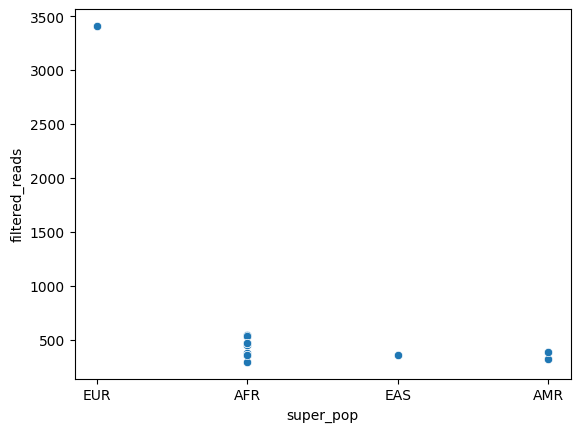

In [11]:
exp_indivs
sns.scatterplot(x='super_pop', y = 'filtered_reads', data = exp_indivs)

## divergent windows

In [37]:
def one_indiv_comps(accession, resolution=10000, nbins=92):
    ind = exp_indivs[exp_indivs['accession']==accession]['full_name'].values[0]

    genome_hic_cool = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession, resolution))

    file_dict = {}
    with open('/wynton/group/capra/projects/modern_human_3Dgenome/data/akitaPreds/3dpreds/HFF_original/3dpreds_%s.txt' % (ind)) as file:
        lines1 = file.readlines()
        for i in range(len(lines1)):
            l1 = lines1[i]
            indiv1 = l1.strip().split("\t")
            indiv1_chr = indiv1[0]
            indiv1_pos = int(indiv1[1])
            indiv1 = list(map(float,indiv1[2:]))
            file_dict[(indiv1_chr, indiv1_pos)] = indiv1

    
    rhos = {}
    mses = {}
    counter = 0
    for chrm, wndw in list(zip(windows_to_keep.chr, windows_to_keep.windowStartPos)):
        keyi = (chrm, wndw)
        if counter % 100 == 0:
            print("%s out of 4873" % counter)
        try:
            exp_target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool, resolution)
            #exp_mat = from_upper_triu(exp_target, nbins, 2)

            ind_pred = file_dict[keyi]
            ind_mat = from_upper_triu(ind_pred, 448, 2)
            ind_mat_compressed = ski.transform.resize(ind_mat, (nbins,nbins), anti_aliasing=False)
            
            rho, p = stats.spearmanr(exp_target, ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)])
            rhos[keyi] = rho

            mse = np.mean(np.square(exp_target - ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)]))
            mses[keyi] = mse
        except:
            rhos[keyi] = np.NaN
            mses[keyi] = np.NaN

        counter += 1

    return mses, rhos


In [38]:
accessions

['4DNFIL76YMY6',
 '4DNFI7N72M2A',
 '4DNFIIDNWL5I',
 '4DNFIEYSPGU1',
 '4DNFI6SJZVXZ',
 '4DNFIOF2U3HX',
 '4DNFI2Y6GTWP',
 '4DNFIKAC7MSF',
 '4DNFIKMV9ZC7',
 '4DNFI78T9N5Y',
 '4DNFIIRNP38T',
 '4DNFIO7M1D22',
 '4DNFI66KARTU',
 '4DNFIUZJP1ED',
 '4DNFIFXDDDJ6']

In [45]:
# #comp_data = {}
# for accession in accessions[:5]:
#     mses, rhos = one_indiv_comps(accession)
#     ind = exp_indivs[exp_indivs['accession']==accession]['full_name'].values[0]

#     comp_data[ind] = mses, rhos

0 out of 4873
100 out of 4873
200 out of 4873
300 out of 4873
400 out of 4873
500 out of 4873
600 out of 4873
700 out of 4873
800 out of 4873
900 out of 4873
1000 out of 4873
1100 out of 4873
1200 out of 4873
1300 out of 4873
1400 out of 4873
1500 out of 4873
1600 out of 4873
1700 out of 4873
1800 out of 4873
1900 out of 4873
2000 out of 4873
2100 out of 4873
2200 out of 4873
2300 out of 4873
2400 out of 4873
2500 out of 4873
2600 out of 4873
2700 out of 4873
2800 out of 4873
2900 out of 4873
3000 out of 4873
3100 out of 4873
3200 out of 4873
3300 out of 4873
3400 out of 4873
3500 out of 4873
3600 out of 4873
3700 out of 4873
3800 out of 4873
3900 out of 4873
4000 out of 4873
4100 out of 4873
4200 out of 4873
4300 out of 4873
4400 out of 4873
4500 out of 4873
4600 out of 4873
4700 out of 4873
4800 out of 4873
0 out of 4873
100 out of 4873
200 out of 4873
300 out of 4873
400 out of 4873
500 out of 4873
600 out of 4873
700 out of 4873
800 out of 4873
900 out of 4873
1000 out of 4873
1100

In [46]:
len(comp_data.keys())

15

In [49]:
# comp_dfs = dict.fromkeys(comp_data.keys())
# for k in comp_data.keys():
#     a = pd.DataFrame.from_dict(comp_data[k][0], orient='index')
#     b = pd.DataFrame.from_dict(comp_data[k][1], orient='index')
#     c = pd.concat([a,b], axis=1)
#     c.columns = ['mse','rho']
#     comp_dfs[k] = c

# comps_df = pd.concat(comp_dfs, axis=1)
# mse = comps_df.swaplevel(0,1, axis=1)['mse']
# rho = comps_df.swaplevel(0,1, axis=1)['rho']
# mse.columns = mse.columns.str.split('_', expand=True)
# rho.columns = rho.columns.str.split('_', expand=True)

In [50]:
# mse.to_csv('%s/intermediates/experimental_vs_predicted_mse.csv' % DATA_PATH)
# rho.to_csv('%s/intermediates/experimental_vs_predicted_rho.csv' % DATA_PATH)

In [276]:
mse = pd.read_csv('%s/intermediates/experimental_vs_predicted_mse.csv' % DATA_PATH, header=[0,1,2,3], index_col=0)
rho = pd.read_csv('%s/intermediates/experimental_vs_predicted_rho.csv' % DATA_PATH, header=[0,1,2,3], index_col=0)
rho.index = pd.MultiIndex.from_frame(windows_to_keep)


In [277]:
rho

AFR                                          \
                           YRI                                           
                          male              female      male    female   
                       NA18516   NA18522   NA19099   NA19141   NA19204   
chr   windowStartPos                                                     
chr1  1048576         0.101756  0.116350  0.130551  0.233664  0.156423   
      1572864         0.281738  0.277834  0.311220  0.223124  0.227871   
      3145728         0.386255  0.297855  0.404067  0.437237  0.441239   
      3670016         0.471025  0.506344  0.470702  0.539548  0.511049   
      4194304         0.111370  0.112703  0.069823 -0.013817 -0.068259   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.195623  0.356036  0.261362  0.360293  0.442375   
      47185920        0.118253 -0.113204  0.096644 -0.010753 -0.033643   
      47710208        0.422553  0.320169  0.413028  0.371700  0.335332   
      48234496        0.123245  0.198542  0.227052  0.169625  0.260496   
      48758784        0.189471  0.284434  0.247862  0.293211  0.353490   

                                               EAS       AMR            \
                                               CHS       PUR             
                                    male    female      male    female   
                       NA19238   NA19239   HG00513   HG00731   HG00732   
chr   windowStartPos                                                     
chr1  1048576         0.204546  0.173319  0.189583  0.084300  0.166628   
      1572864         0.291264  0.262315  0.314239  0.324277  0.268271   
      3145728         0.499972  0.401942  0.371267  0.397396  0.353502   
      3670016         0.525122  0.426674  0.351678  0.476864  0.366208   
      4194304         0.015015  0.042961  0.069985  0.136620  0.068868   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.330730  0.296100  0.215562  0.389258  0.368633   
      47185920        0.019400  0.046475  0.248933 -0.010680 -0.005492   
      47710208        0.283433  0.292214  0.275921  0.365625  0.309123   
      48234496        0.303687  0.216561  0.222669  0.223030  0.332358   
      48758784        0.205658  0.165637  0.343448  0.041397  0.279732   

                           EUR       AFR                                
                           CEU       YRI                                
                        female      male    female      male    female  
                       NA12878   NA18486   NA18505   NA18507   NA18508  
chr   windowStartPos                                                    
chr1  1048576         0.131721  0.098992  0.143273  0.182908  0.100142  
      1572864         0.354554  0.222419  0.309716  0.274542  0.376682  
      3145728         0.464246  0.329380  0.364095  0.428658  0.400297  
      3670016         0.660571  0.542687  0.441574  0.552592  0.464809  
      4194304         0.078875  0.179134  0.033160 -0.021245  0.040814  
...                        ...       ...       ...       ...       ...  
chr22 46661632        0.571779  0.338709  0.300375  0.313404  0.231153  
      47185920        0.128504  0.125811  0.055419  0.155952  0.088081  
      47710208        0.266307  0.483506  0.364536  0.312686  0.421830  
      48234496        0.266009  0.237060  0.274887  0.128082  0.152681  
      48758784        0.214102  0.282057  0.212282  0.065052  0.270173  

[4873 rows x 15 columns]

In [52]:
anc

ancestor  genome_avg_mse  genome_avg_spearman  \
1KG                                                                             
AFR_ACB_female_HG01880  hsmrca_ancestral        0.000654             0.995720   
AFR_ACB_female_HG01883  hsmrca_ancestral        0.000688             0.995387   
AFR_ACB_female_HG01886  hsmrca_ancestral        0.000680             0.995517   
AFR_ACB_female_HG01889  hsmrca_ancestral        0.000709             0.995272   
AFR_ACB_female_HG01894  hsmrca_ancestral        0.000683             0.995589   
...                                  ...             ...                  ...   
SAS_STU_male_HG04039    hsmrca_ancestral        0.000642             0.995748   
SAS_STU_male_HG04100    hsmrca_ancestral        0.000664             0.995672   
SAS_STU_male_HG04107    hsmrca_ancestral        0.000671             0.995665   
SAS_STU_male_HG04210    hsmrca_ancestral        0.000663             0.995597   
SAS_STU_male_HG04229    hsmrca_ancestral        0.000669             0.995534   

                       super_pop sub_pop     sex       id  divergence  \
1KG                                                                     
AFR_ACB_female_HG01880       AFR     ACB  female  HG01880    0.004280   
AFR_ACB_female_HG01883       AFR     ACB  female  HG01883    0.004613   
AFR_ACB_female_HG01886       AFR     ACB  female  HG01886    0.004483   
AFR_ACB_female_HG01889       AFR     ACB  female  HG01889    0.004728   
AFR_ACB_female_HG01894       AFR     ACB  female  HG01894    0.004411   
...                          ...     ...     ...      ...         ...   
SAS_STU_male_HG04039         SAS     STU    male  HG04039    0.004252   
SAS_STU_male_HG04100         SAS     STU    male  HG04100    0.004328   
SAS_STU_male_HG04107         SAS     STU    male  HG04107    0.004335   
SAS_STU_male_HG04210         SAS     STU    male  HG04210    0.004403   
SAS_STU_male_HG04229         SAS     STU    male  HG04229    0.004466   

                                     full_name  
1KG                                             
AFR_ACB_female_HG01880  AFR_ACB_female_HG01880  
AFR_ACB_female_HG01883  AFR_ACB_female_HG01883  
AFR_ACB_female_HG01886  AFR_ACB_female_HG01886  
AFR_ACB_female_HG01889  AFR_ACB_female_HG01889  
AFR_ACB_female_HG01894  AFR_ACB_female_HG01894  
...                                        ...  
SAS_STU_male_HG04039      SAS_STU_male_HG04039  
SAS_STU_male_HG04100      SAS_STU_male_HG04100  
SAS_STU_male_HG04107      SAS_STU_male_HG04107  
SAS_STU_male_HG04210      SAS_STU_male_HG04210  
SAS_STU_male_HG04229      SAS_STU_male_HG04229  

[2457 rows x 9 columns]

In [166]:
def exp_pred_comp(ind, chrm, wndw, resolution = 10000, sat = 0.6, nbins = 92):
    accession_ind = exp_indivs[exp_indivs.full_name==ind].accession.values[0]
    genome_hic_cool_ind = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_ind, resolution))
    exp_target_ind = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_ind, resolution)

    ind_seq_ind = get_seq(chrm, wndw, ind)
    ind_pred_ind = runAkitaPreds(ind_seq_ind)

    ind_mat = from_upper_triu(ind_pred_ind, 448, 2)
    ind_mat_compressed = ski.transform.resize(ind_mat, (nbins,nbins), anti_aliasing=False)
    #rho, p = stats.spearmanr(exp_target_ind, ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)])

    exp = visualize_map_exp(exp_target_ind,ind, wndw, chrm, s=nbins, res=resolution, cbar=False, sat = sat)
    pred = visualize_map_compressed(ind_pred_ind, wndw, ind, chrm, s=nbins, res=resolution, sat = sat)

    return rho, exp, pred

EUR_CEU_female_NA12878
1/1 [==============================] - 1s 1s/step


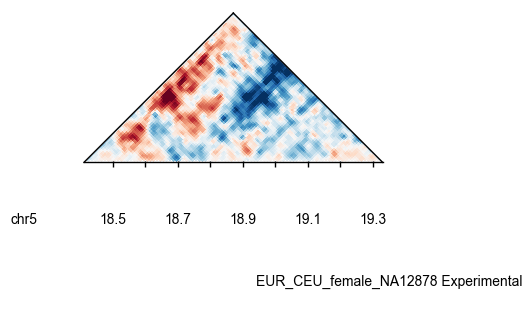

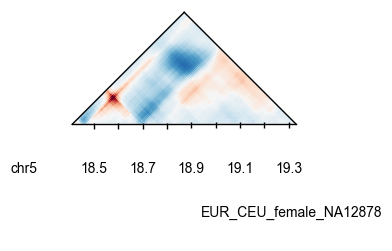

EUR_CEU_female_NA12878 -0.11057347968987366
AFR_YRI_male_NA18486
1/1 [==============================] - 1s 1s/step


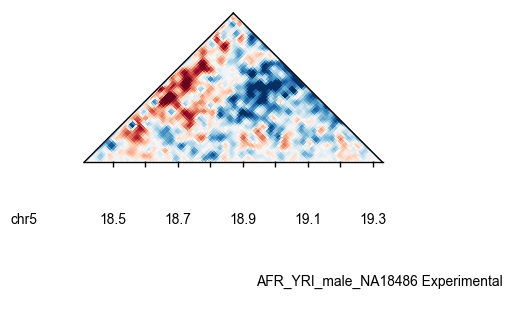

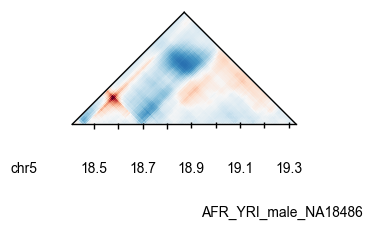

AFR_YRI_male_NA18486 -0.11507051056745998
AFR_YRI_female_NA18505
1/1 [==============================] - 1s 1s/step


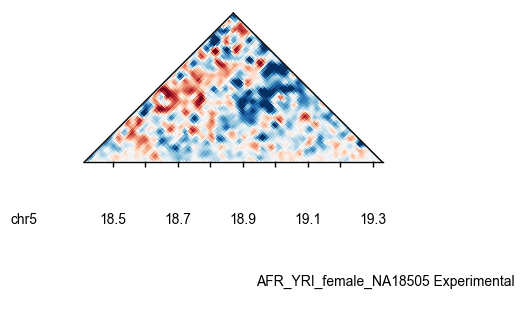

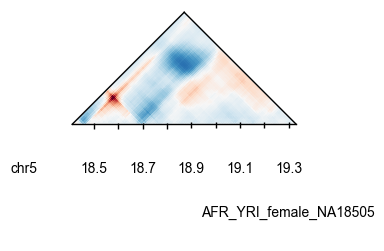

AFR_YRI_female_NA18505 -0.11487886316606423
AFR_YRI_male_NA18507
1/1 [==============================] - 1s 1s/step


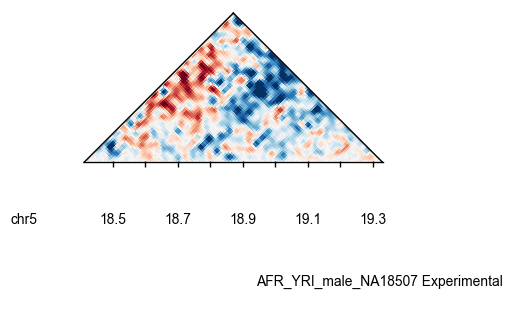

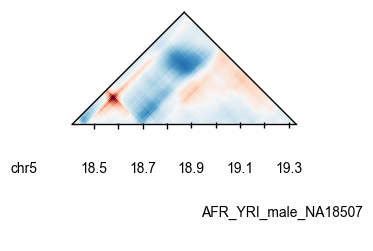

AFR_YRI_male_NA18507 -0.1547492982353631
AFR_YRI_female_NA18508
1/1 [==============================] - 1s 1s/step


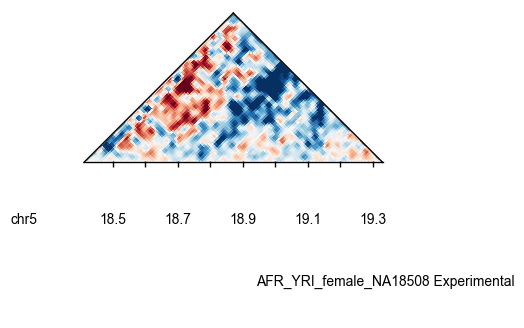

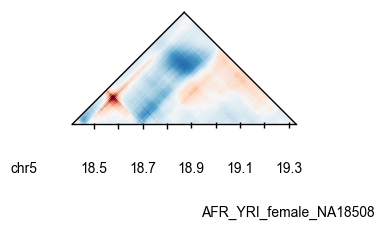

AFR_YRI_female_NA18508 -0.20213021641063475
AFR_YRI_male_NA18516
1/1 [==============================] - 1s 1s/step


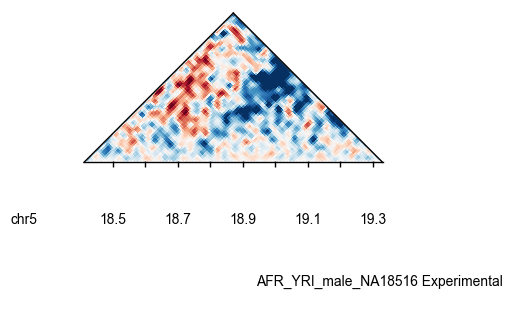

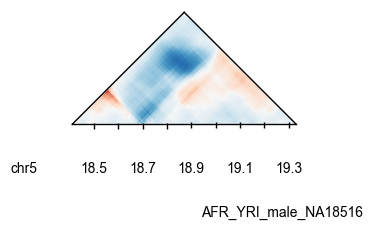

AFR_YRI_male_NA18516 -0.3729296661507096
AFR_YRI_male_NA18522
1/1 [==============================] - 1s 1s/step


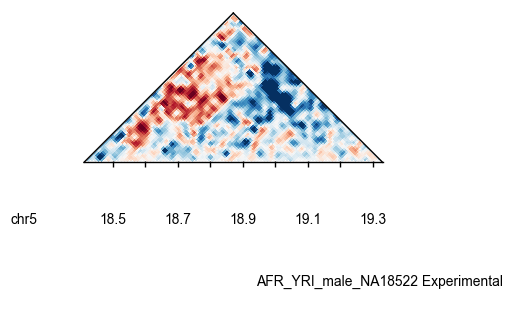

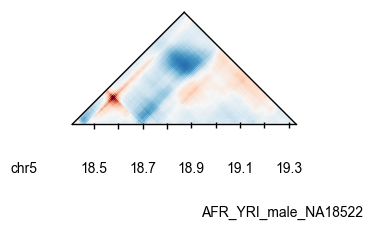

AFR_YRI_male_NA18522 -0.2127189287155467
AFR_YRI_female_NA19099
1/1 [==============================] - 1s 1s/step


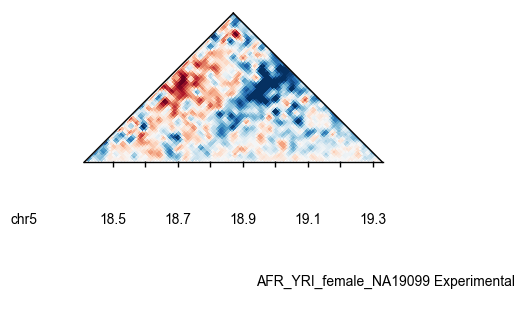

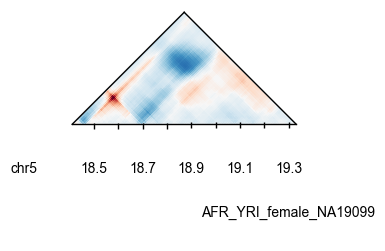

AFR_YRI_female_NA19099 -0.14693186230227565
AFR_YRI_male_NA19141
1/1 [==============================] - 1s 1s/step


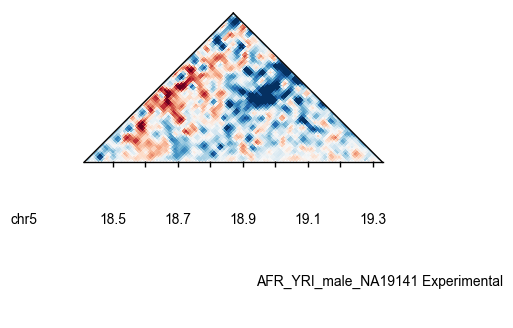

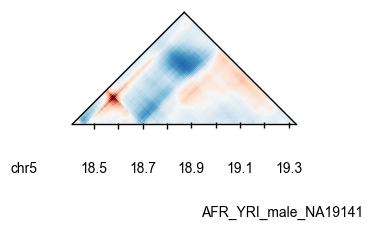

AFR_YRI_male_NA19141 -0.08980231970333545
AFR_YRI_female_NA19204
1/1 [==============================] - 1s 1s/step


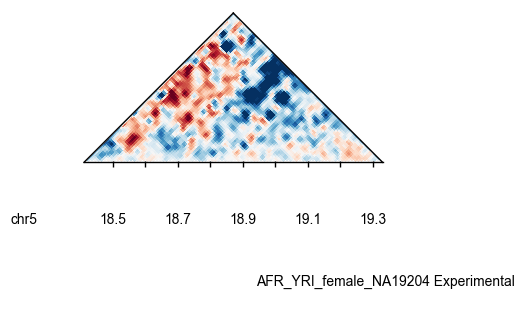

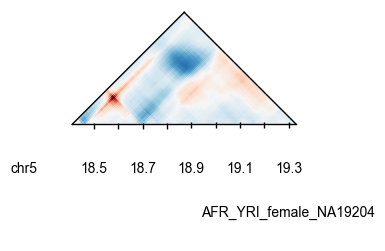

AFR_YRI_female_NA19204 -0.11759247177843485
AFR_YRI_female_NA19238
1/1 [==============================] - 1s 1s/step


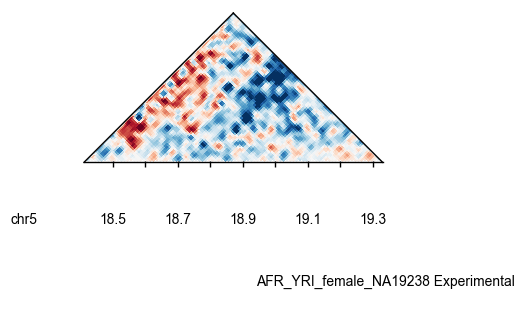

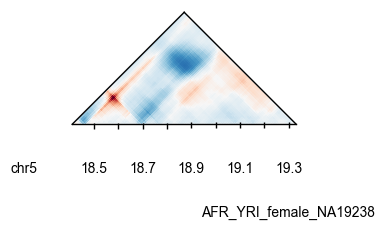

AFR_YRI_female_NA19238 -0.05785781586475578
AFR_YRI_male_NA19239
1/1 [==============================] - 1s 1s/step


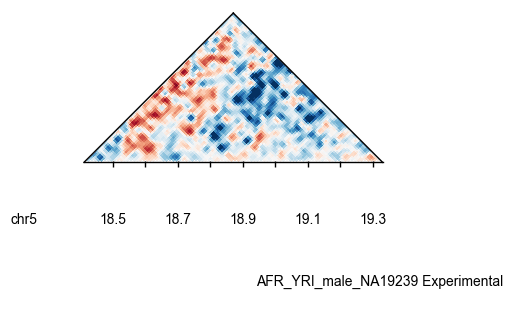

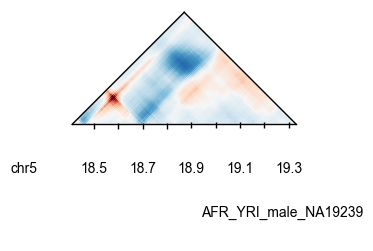

AFR_YRI_male_NA19239 -0.06989836104374736
EAS_CHS_female_HG00513
1/1 [==============================] - 1s 1s/step


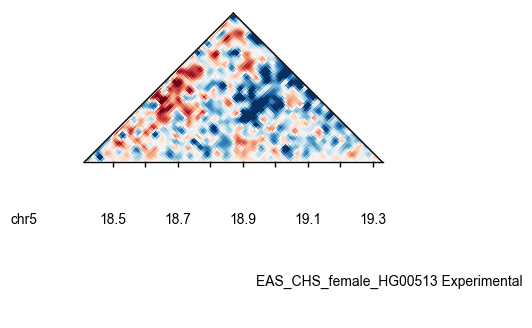

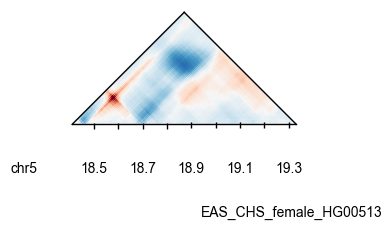

EAS_CHS_female_HG00513 -0.04552548579032645
AMR_PUR_male_HG00731
1/1 [==============================] - 1s 1s/step


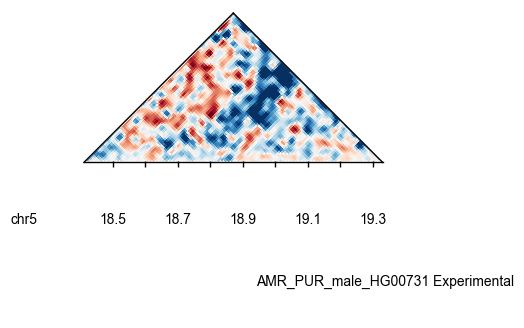

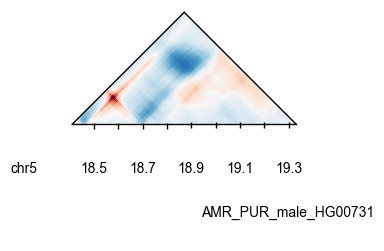

AMR_PUR_male_HG00731 -0.14743923024171454
AMR_PUR_female_HG00732
1/1 [==============================] - 1s 1s/step


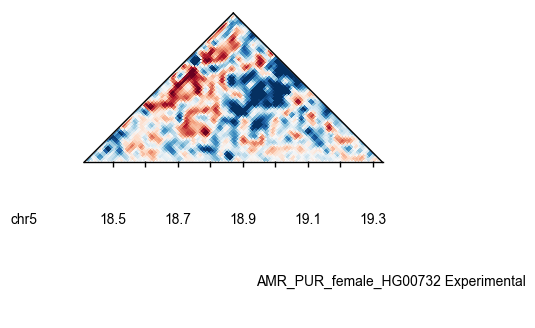

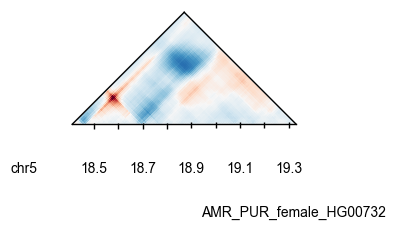

AMR_PUR_female_HG00732 -0.13909518928784606


In [66]:
divergent_windows = pd.read_csv('%s/divergent_windows_exp_distributions.txt' % DATA_PATH)

In [72]:
divergent_windows

chr  windowStartPos  ttest_stat     ttest_pval  obs_mean  exp_mean  \
0     chr1        41418752  -26.987165  1.461871e-143  0.011143  0.003190   
1     chr1        57147392  -11.867927   9.060743e-32  0.021517  0.007885   
2     chr1        70778880   -5.334215   1.032114e-07  0.003761  0.002849   
3     chr1        88604672  -17.578602   7.272380e-66  0.014955  0.002522   
4     chr1        92798976  -16.384539   8.147811e-58  0.071182  0.008426   
..     ...             ...         ...            ...       ...       ...   
387  chr21        35127296   -8.395653   7.093248e-17  0.030532  0.022997   
388  chr22        22020096  -10.467888   3.332675e-25  0.023887  0.017606   
389  chr22        22544384   -9.387509   1.188089e-20  0.011776  0.007743   
390  chr22        47710208  -26.485256  7.297025e-139  0.055388  0.020211   
391  chr22        48234496  -55.442420   0.000000e+00  0.204145  0.035823   

      obs/exp   obs-exp   -log10(p) direction  ...       ALL       AFR  \
0    3.492743  0.007953  142.835091    higher  ...  0.011143  0.010108   
1    2.728665  0.013631   31.042836    higher  ...  0.021517  0.009149   
2    1.319976  0.000912    6.986272    higher  ...  0.003761  0.003670   
3    5.929643  0.012433   65.138323    higher  ...  0.014955  0.007492   
4    8.447434  0.062755   57.088959    higher  ...  0.071182  0.062220   
..        ...       ...         ...       ...  ...       ...       ...   
387  1.327648  0.007535   16.149155    higher  ...  0.030532  0.034489   
388  1.356793  0.006282   24.477207    higher  ...  0.023887  0.027355   
389  1.520958  0.004034   19.925151    higher  ...  0.011776  0.015540   
390  2.740559  0.035178  138.136854    higher  ...  0.055388  0.055222   
391  5.698711  0.168322         inf    higher  ...  0.204145  0.204803   

          EUR       EAS       SAS       AMR       min       max   emp_min  \
0    0.011830  0.013180  0.011994  0.008076  0.000214  0.061708  0.000240   
1    0.031168  0.016713  0.022907  0.036207  0.000460  0.241914  0.000711   
2    0.003780  0.003793  0.003737  0.003891  0.000125  0.015220  0.000125   
3    0.022346  0.014407  0.018429  0.014783  0.000098  0.068938  0.000080   
4    0.047517  0.096720  0.079656  0.074693  0.000381  0.260017  0.000371   
..        ...       ...       ...       ...       ...       ...       ...   
387  0.028786  0.028111  0.029609  0.030236  0.008522  0.120146  0.001044   
388  0.024776  0.021138  0.021943  0.022474  0.001957  0.055087  0.001038   
389  0.012083  0.008256  0.011551  0.009572  0.000380  0.032310  0.000370   
390  0.060998  0.053654  0.047932  0.059584  0.001600  0.142327  0.001173   
391  0.214279  0.197077  0.187644  0.219469  0.002814  0.346398  0.002023   

      emp_max  
0    0.047160  
1    0.198873  
2    0.071377  
3    0.055810  
4    0.454930  
..        ...  
387  0.323117  
388  0.190579  
389  0.141347  
390  0.203276  
391  0.280502  

[392 rows x 23 columns]

In [87]:
windows_to_keep[windows_to_keep.chr=='chr1'][windows_to_keep.windowStartPos==41418752]

chr  windowStartPos
69  chr1        41418752

In [90]:
rho

AFR                                          \
                          YRI                                           
                         male              female      male    female   
                      NA18516   NA18522   NA19099   NA19141   NA19204   
('chr1', 1048576)    0.101756  0.116350  0.130551  0.233664  0.156423   
('chr1', 1572864)    0.281738  0.277834  0.311220  0.223124  0.227871   
('chr1', 3145728)    0.386255  0.297855  0.404067  0.437237  0.441239   
('chr1', 3670016)    0.471025  0.506344  0.470702  0.539548  0.511049   
('chr1', 4194304)    0.111370  0.112703  0.069823 -0.013817 -0.068259   
...                       ...       ...       ...       ...       ...   
('chr22', 46661632)  0.195623  0.356036  0.261362  0.360293  0.442375   
('chr22', 47185920)  0.118253 -0.113204  0.096644 -0.010753 -0.033643   
('chr22', 47710208)  0.422553  0.320169  0.413028  0.371700  0.335332   
('chr22', 48234496)  0.123245  0.198542  0.227052  0.169625  0.260496   
('chr22', 48758784)  0.189471  0.284434  0.247862  0.293211  0.353490   

                                              EAS       AMR            \
                                              CHS       PUR             
                                   male    female      male    female   
                      NA19238   NA19239   HG00513   HG00731   HG00732   
('chr1', 1048576)    0.204546  0.173319  0.189583  0.084300  0.166628   
('chr1', 1572864)    0.291264  0.262315  0.314239  0.324277  0.268271   
('chr1', 3145728)    0.499972  0.401942  0.371267  0.397396  0.353502   
('chr1', 3670016)    0.525122  0.426674  0.351678  0.476864  0.366208   
('chr1', 4194304)    0.015015  0.042961  0.069985  0.136620  0.068868   
...                       ...       ...       ...       ...       ...   
('chr22', 46661632)  0.330730  0.296100  0.215562  0.389258  0.368633   
('chr22', 47185920)  0.019400  0.046475  0.248933 -0.010680 -0.005492   
('chr22', 47710208)  0.283433  0.292214  0.275921  0.365625  0.309123   
('chr22', 48234496)  0.303687  0.216561  0.222669  0.223030  0.332358   
('chr22', 48758784)  0.205658  0.165637  0.343448  0.041397  0.279732   

                          EUR       AFR                                
                          CEU       YRI                                
                       female      male    female      male    female  
                      NA12878   NA18486   NA18505   NA18507   NA18508  
('chr1', 1048576)    0.131721  0.098992  0.143273  0.182908  0.100142  
('chr1', 1572864)    0.354554  0.222419  0.309716  0.274542  0.376682  
('chr1', 3145728)    0.464246  0.329380  0.364095  0.428658  0.400297  
('chr1', 3670016)    0.660571  0.542687  0.441574  0.552592  0.464809  
('chr1', 4194304)    0.078875  0.179134  0.033160 -0.021245  0.040814  
...                       ...       ...       ...       ...       ...  
('chr22', 46661632)  0.571779  0.338709  0.300375  0.313404  0.231153  
('chr22', 47185920)  0.128504  0.125811  0.055419  0.155952  0.088081  
('chr22', 47710208)  0.266307  0.483506  0.364536  0.312686  0.421830  
('chr22', 48234496)  0.266009  0.237060  0.274887  0.128082  0.152681  
('chr22', 48758784)  0.214102  0.282057  0.212282  0.065052  0.270173  

[4873 rows x 15 columns]

In [105]:
divergent_val

AFR                                          \
                           YRI                                           
                          male    female      male    female             
                       NA18522   NA19099   NA19141   NA19204   NA19238   
chr   windowStartPos                                                     
chr1  41418752        0.751389  0.725256  0.721564  0.739827  0.712765   
      57147392        0.047402  0.062009  0.041578  0.059524  0.107329   
      70778880        0.498016  0.537075  0.556722  0.552945  0.554380   
      88604672        0.822399  0.846042  0.885288  0.850938  0.830528   
      92798976        0.361634  0.415404  0.486227  0.468223  0.406868   
...                        ...       ...       ...       ...       ...   
chr21 35127296        0.295247  0.327378  0.373560  0.484830  0.338275   
chr22 22020096        0.287825  0.230030  0.226638  0.153346  0.224830   
      22544384        0.527348  0.382598  0.375266  0.518478  0.466287   
      47710208        0.320169  0.413028  0.371700  0.335332  0.283433   
      48234496        0.198542  0.227052  0.169625  0.260496  0.303687   

                                     EAS       AMR                 EUR  \
                                     CHS       PUR                 CEU   
                          male    female      male    female    female   
                       NA19239   HG00513   HG00731   HG00732   NA12878   
chr   windowStartPos                                                     
chr1  41418752        0.743543  0.716369  0.722686  0.711975  0.749015   
      57147392        0.135096 -0.004868  0.052219  0.087904  0.110523   
      70778880        0.489383  0.380623  0.391300  0.412704  0.584654   
      88604672        0.827526  0.812807  0.763174  0.775428  0.838223   
      92798976        0.446968  0.371284  0.374051  0.297155  0.442062   
...                        ...       ...       ...       ...       ...   
chr21 35127296        0.325396  0.199515  0.312804  0.256172  0.483122   
chr22 22020096        0.267066  0.365475  0.337743  0.251038  0.284601   
      22544384        0.463007  0.429474  0.478130  0.377662  0.584775   
      47710208        0.292214  0.275921  0.365625  0.309123  0.266307   
      48234496        0.216561  0.222669  0.223030  0.332358  0.266009   

                           AFR                                     avg  
                           YRI                                          
                          male    female      male    female            
                       NA18486   NA18505   NA18507   NA18508            
chr   windowStartPos                                                    
chr1  41418752        0.749213  0.691171  0.734940  0.717358  0.727648  
      57147392        0.020090  0.113251  0.034149 -0.008047  0.061297  
      70778880        0.525673  0.458993  0.588995  0.469634  0.500078  
      88604672        0.852839  0.830051  0.831682  0.829760  0.828335  
      92798976        0.431012  0.457713  0.454106  0.316192  0.409207  
...                        ...       ...       ...       ...       ...  
chr21 35127296        0.425997  0.317350  0.353424  0.145077  0.331296  
chr22 22020096        0.206077  0.335529  0.260510  0.192738  0.258817  
      22544384        0.432842  0.596875  0.312761  0.478364  0.458848  
      47710208        0.483506  0.364536  0.312686  0.421830  0.343958  
      48234496        0.237060  0.274887  0.128082  0.152681  0.229481  

[392 rows x 15 columns]

In [107]:
divergent_windows['obs-exp']

0      0.007953
1      0.013631
2      0.000912
3      0.012433
4      0.062755
         ...   
387    0.007535
388    0.006282
389    0.004034
390    0.035178
391    0.168322
Name: obs-exp, Length: 392, dtype: float64

In [115]:
divergent_val = rho.loc[list(zip(divergent_windows.chr, divergent_windows.windowStartPos))]
divergent_val['avg'] = divergent_val.mean(axis=1)
divergent_val['obs-exp'] = np.array(divergent_windows['obs-exp'])


In [359]:
anc

ancestor  genome_avg_mse  genome_avg_spearman  \
1KG                                                                             
AFR_ACB_female_HG01880  hsmrca_ancestral        0.000654             0.995720   
AFR_ACB_female_HG01883  hsmrca_ancestral        0.000688             0.995387   
AFR_ACB_female_HG01886  hsmrca_ancestral        0.000680             0.995517   
AFR_ACB_female_HG01889  hsmrca_ancestral        0.000709             0.995272   
AFR_ACB_female_HG01894  hsmrca_ancestral        0.000683             0.995589   
...                                  ...             ...                  ...   
SAS_STU_male_HG04039    hsmrca_ancestral        0.000642             0.995748   
SAS_STU_male_HG04100    hsmrca_ancestral        0.000664             0.995672   
SAS_STU_male_HG04107    hsmrca_ancestral        0.000671             0.995665   
SAS_STU_male_HG04210    hsmrca_ancestral        0.000663             0.995597   
SAS_STU_male_HG04229    hsmrca_ancestral        0.000669             0.995534   

                       super_pop sub_pop     sex       id  divergence  \
1KG                                                                     
AFR_ACB_female_HG01880       AFR     ACB  female  HG01880    0.004280   
AFR_ACB_female_HG01883       AFR     ACB  female  HG01883    0.004613   
AFR_ACB_female_HG01886       AFR     ACB  female  HG01886    0.004483   
AFR_ACB_female_HG01889       AFR     ACB  female  HG01889    0.004728   
AFR_ACB_female_HG01894       AFR     ACB  female  HG01894    0.004411   
...                          ...     ...     ...      ...         ...   
SAS_STU_male_HG04039         SAS     STU    male  HG04039    0.004252   
SAS_STU_male_HG04100         SAS     STU    male  HG04100    0.004328   
SAS_STU_male_HG04107         SAS     STU    male  HG04107    0.004335   
SAS_STU_male_HG04210         SAS     STU    male  HG04210    0.004403   
SAS_STU_male_HG04229         SAS     STU    male  HG04229    0.004466   

                                     full_name  
1KG                                             
AFR_ACB_female_HG01880  AFR_ACB_female_HG01880  
AFR_ACB_female_HG01883  AFR_ACB_female_HG01883  
AFR_ACB_female_HG01886  AFR_ACB_female_HG01886  
AFR_ACB_female_HG01889  AFR_ACB_female_HG01889  
AFR_ACB_female_HG01894  AFR_ACB_female_HG01894  
...                                        ...  
SAS_STU_male_HG04039      SAS_STU_male_HG04039  
SAS_STU_male_HG04100      SAS_STU_male_HG04100  
SAS_STU_male_HG04107      SAS_STU_male_HG04107  
SAS_STU_male_HG04210      SAS_STU_male_HG04210  
SAS_STU_male_HG04229      SAS_STU_male_HG04229  

[2457 rows x 9 columns]

In [121]:
divergent_val[divergent_val['avg'] > 0.8]

AFR                                          \
                           YRI                                           
                          male    female      male    female             
                       NA18522   NA19099   NA19141   NA19204   NA19238   
chr   windowStartPos                                                     
chr1  88604672        0.822399  0.846042  0.885288  0.850938  0.830528   
chr3  101711872       0.841373  0.833790  0.847211  0.825508  0.815446   
chr5  33030144        0.825722  0.827041  0.841708  0.812401  0.830490   
chr11 34603008        0.829531  0.798183  0.808329  0.806879  0.798105   
chr20 5242880         0.828161  0.824003  0.820362  0.840036  0.823747   

                                     EAS       AMR                 EUR  \
                                     CHS       PUR                 CEU   
                          male    female      male    female    female   
                       NA19239   HG00513   HG00731   HG00732   NA12878   
chr   windowStartPos                                                     
chr1  88604672        0.827526  0.812807  0.763174  0.775428  0.838223   
chr3  101711872       0.829361  0.749651  0.769811  0.776788  0.846083   
chr5  33030144        0.822141  0.762690  0.773553  0.773341  0.829516   
chr11 34603008        0.809587  0.776884  0.759189  0.782375  0.836977   
chr20 5242880         0.827483  0.781910  0.762594  0.798577  0.840174   

                           AFR                                     avg  \
                           YRI                                           
                          male    female      male    female             
                       NA18486   NA18505   NA18507   NA18508             
chr   windowStartPos                                                     
chr1  88604672        0.852839  0.830051  0.831682  0.829760  0.828335   
chr3  101711872       0.826352  0.830171  0.831683  0.815801  0.817074   
chr5  33030144        0.811835  0.834674  0.844510  0.795518  0.813224   
chr11 34603008        0.827751  0.812026  0.786411  0.786366  0.801328   
chr20 5242880         0.833434  0.831591  0.810364  0.809610  0.816575   

                       obs-exp  
                                
                                
                                
chr   windowStartPos            
chr1  88604672        0.012433  
chr3  101711872       0.000606  
chr5  33030144        0.007141  
chr11 34603008        0.000542  
chr20 5242880         0.002457

(array([ 2.,  2., 23., 47., 30., 51., 65., 86., 55., 20.]),
 array([-0.31177341, -0.1977626 , -0.08375178,  0.03025904,  0.14426985,
         0.25828067,  0.37229148,  0.4863023 ,  0.60031312,  0.71432393,
         0.82833475]),
 <BarContainer object of 10 artists>)

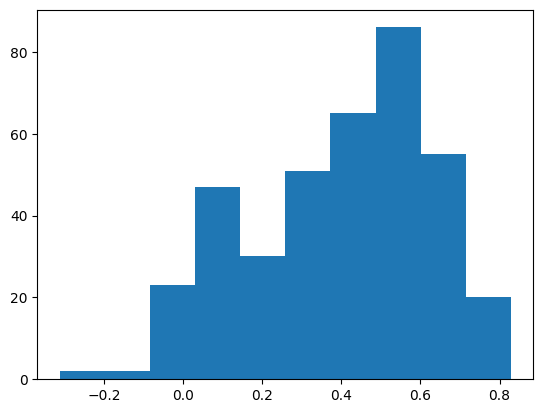

In [100]:
plt.hist(divergent_val.avg)

In [355]:
def simple_map_comparison(ind1, ind2, chr, start, s, res, sat = 1, title = 'sample'):
    
    ind1_mat = ind1
    ind2_mat = ind2

    fig1, axes = plt.subplots(3, 1, figsize=(20,15))

    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1_exp(fig1, 311, -45, s)
    ax1 = setup_axes1_exp(fig1, 312, -45, s)
    ax2 = setup_axes1_exp(fig1, 313, -45, s)

    # ax0.set_position([0, 0.62, .1, .1])
    # ax1.set_position([0, 0.31, .1, .1])
    # ax2.set_position([0, 0, .1, .1])
    
    ax0.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax = sat)
    ax1.matshow(ind2_mat, cmap = 'RdBu_r', vmin = -sat, vmax = sat)
    ax2.matshow(ind2_mat - ind1_mat, cmap = 'PRGn_r', vmin = -(sat/2), vmax = (sat/2))
    
    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, s-1], [0, s], color = 'black', linewidth = 0.70821529745) # bottom line
        n.plot([-1, s-1], [s, s], color = 'black', linewidth = 0.70821529745) # right line
        n.plot([-1, -1], [s, 0], color = 'black', linewidth = 0.70821529745) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/res
    
    x_list = np.arange(cell, s, (100000/res))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 5)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 9)
    
    # subpanel labels
    # ax0.text(290, 158, ind1, horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    # ax1.text(290, 158, ind2, horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    # ax2.text(290, 158, r'$\Delta$', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    
    plt.savefig('results/plots/%s.svg' % (title), bbox_inches = 'tight', transparent = True, dpi = 400);
    plt.show()

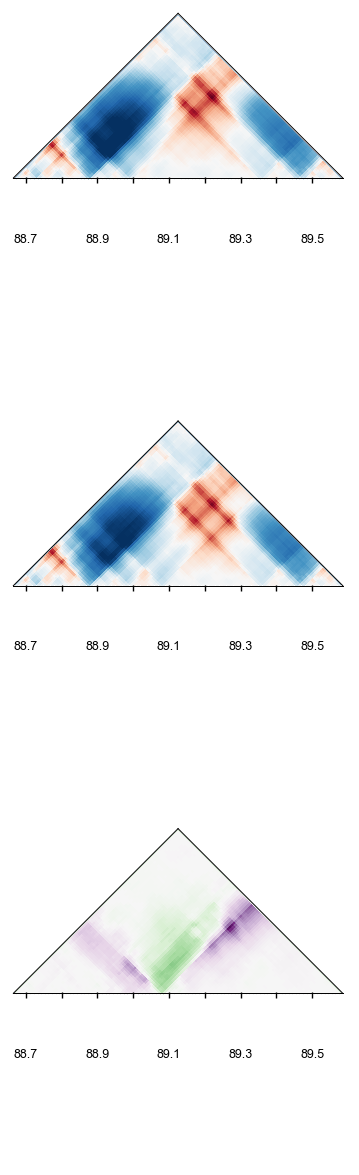

In [356]:
simple_map_comparison(pred1, pred2, chrm, wndw, s=nbins, res = resolution, sat = 1.5, title = 'experimental_example_predictions')

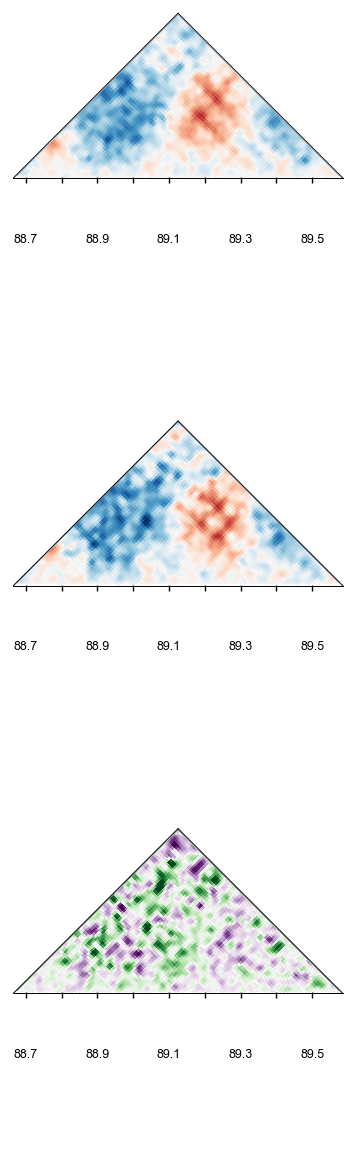

In [357]:
simple_map_comparison(exp1, exp2, chrm, wndw, s = nbins, res = resolution, sat = 1.5, title = 'experimental_example_experimental')

1/1 [==============================] - 1s 1s/step


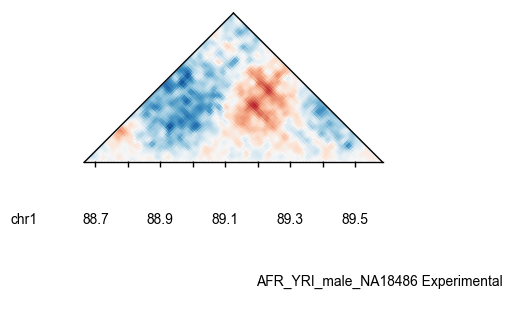

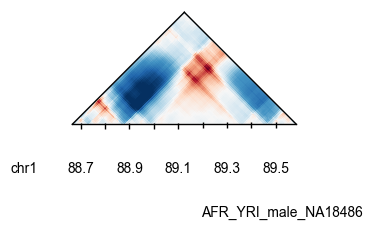

1/1 [==============================] - 1s 1s/step


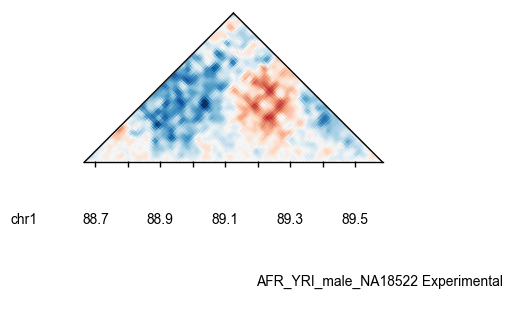

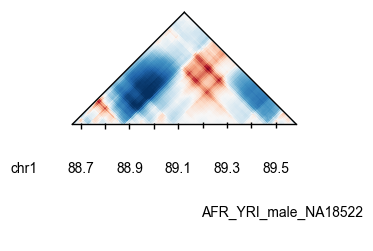

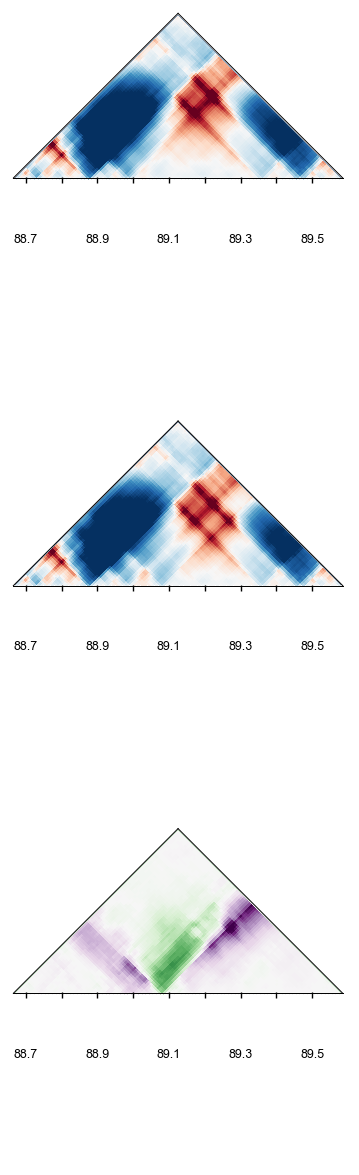

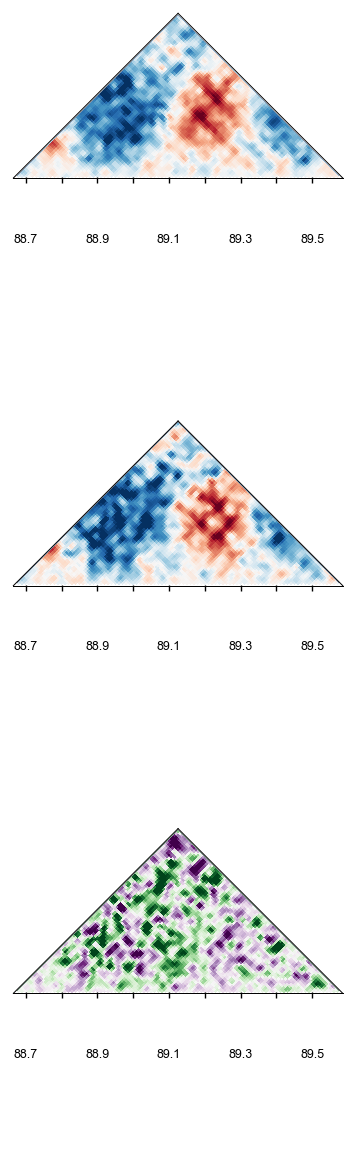

In [350]:
ind1 = 'AFR_YRI_male_NA18486'
ind2 = 'AFR_YRI_male_NA18522'
chrm = 'chr1'
wndw = 88604672
resolution = 10000
nbins = 92
sat = 1.5

spear1, exp1, pred1 = exp_pred_comp(ind1, chrm, wndw, sat=1.5, nbins=nbins, resolution = resolution)
spear2, exp2, pred2 = exp_pred_comp(ind2, chrm, wndw, sat=1.5, nbins = nbins, resolution = resolution)

simple_map_comparison(pred1, pred2, chrm, wndw, s=nbins, res = resolution)
simple_map_comparison(exp1, exp2, chrm, wndw, s = nbins, res = resolution)


EUR_CEU_female_NA12878
1/1 [==============================] - 1s 1s/step


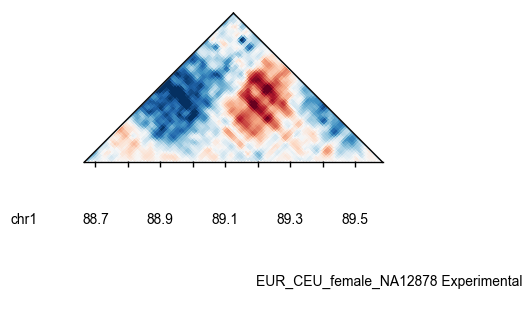

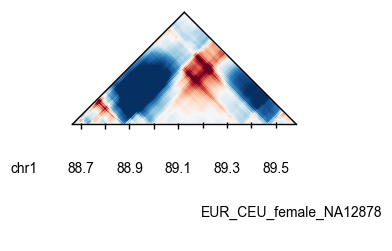

EUR_CEU_female_NA12878 0.838223171370383
AFR_YRI_male_NA18486
1/1 [==============================] - 1s 1s/step


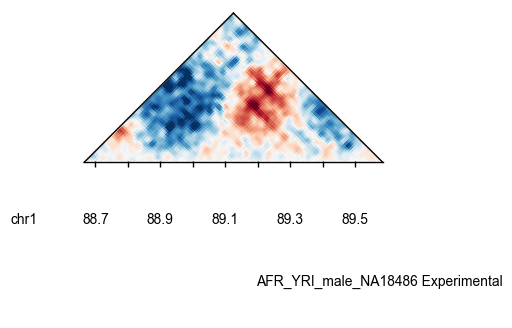

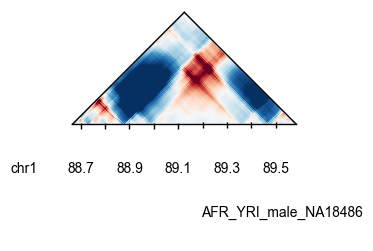

AFR_YRI_male_NA18486 0.8528391354800965
AFR_YRI_female_NA18505
1/1 [==============================] - 1s 1s/step


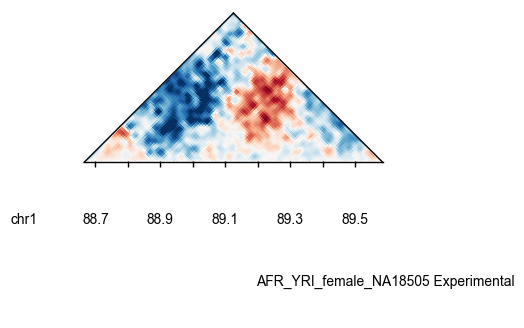

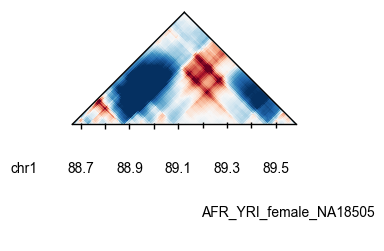

AFR_YRI_female_NA18505 0.8300508187788443
AFR_YRI_male_NA18507
1/1 [==============================] - 1s 1s/step


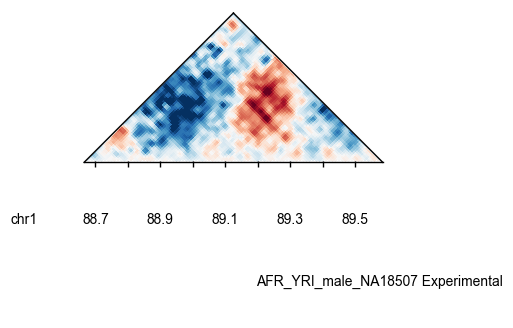

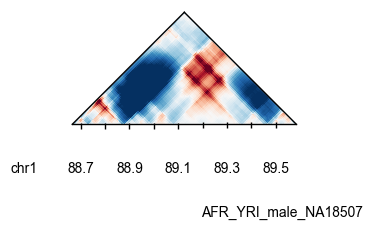

AFR_YRI_male_NA18507 0.8316816473666417
AFR_YRI_female_NA18508
1/1 [==============================] - 1s 1s/step


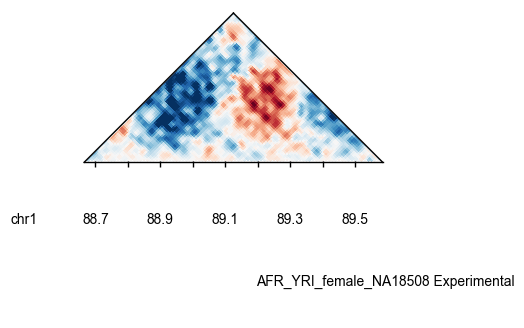

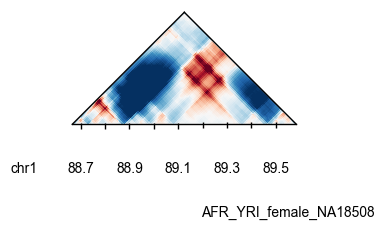

AFR_YRI_female_NA18508 0.829760720036511
AFR_YRI_male_NA18516
1/1 [==============================] - 1s 1s/step


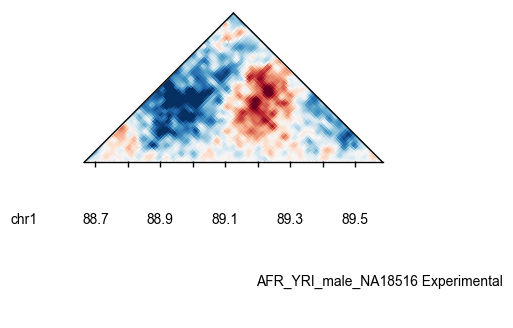

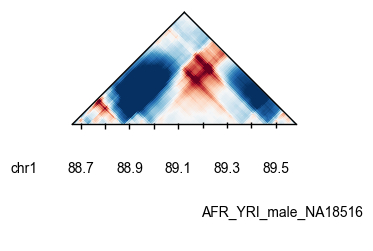

AFR_YRI_male_NA18516 0.8321605143799539
AFR_YRI_male_NA18522
1/1 [==============================] - 1s 1s/step


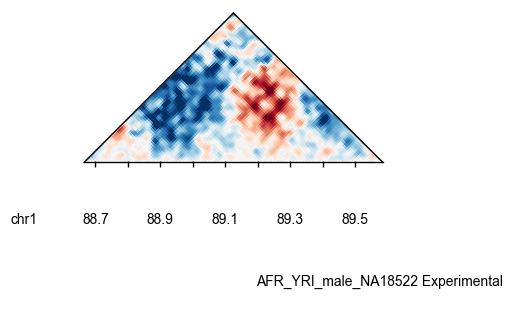

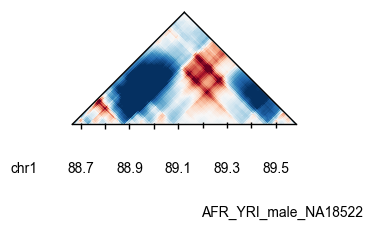

AFR_YRI_male_NA18522 0.8223990067462909
AFR_YRI_female_NA19099
1/1 [==============================] - 1s 937ms/step


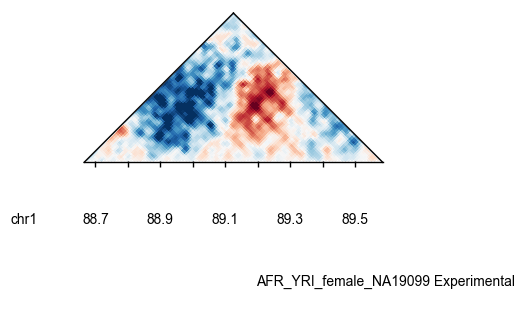

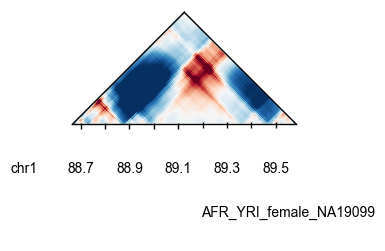

AFR_YRI_female_NA19099 0.846042381545247
AFR_YRI_male_NA19141
1/1 [==============================] - 1s 1s/step


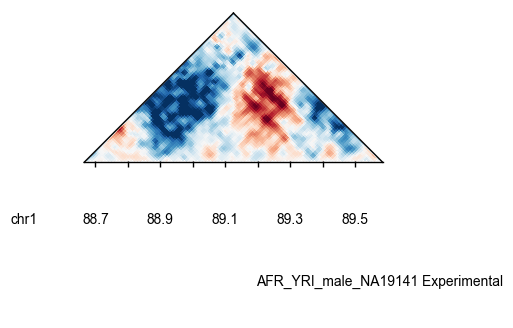

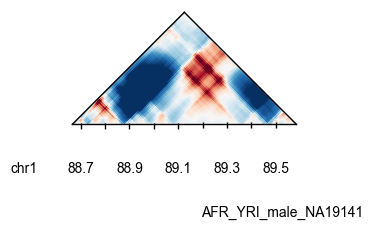

AFR_YRI_male_NA19141 0.8852876834270083
AFR_YRI_female_NA19204
1/1 [==============================] - 1s 1s/step


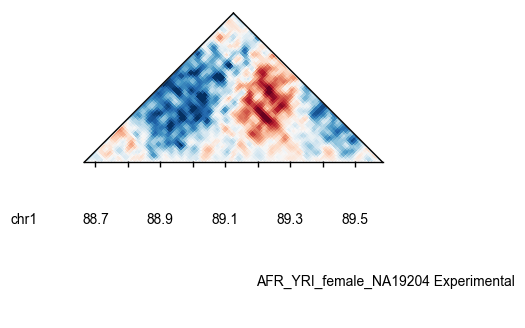

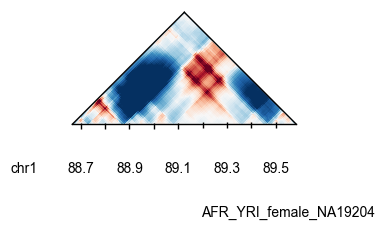

AFR_YRI_female_NA19204 0.8509382216638769
AFR_YRI_female_NA19238
1/1 [==============================] - 1s 1s/step


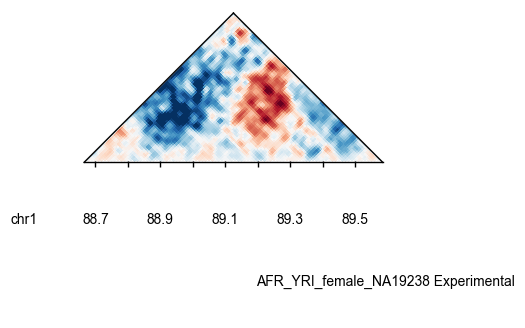

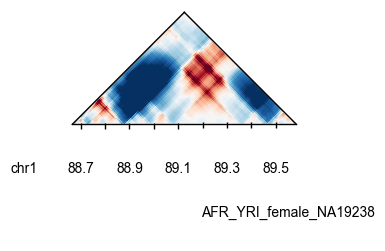

AFR_YRI_female_NA19238 0.8305285477372268
AFR_YRI_male_NA19239
1/1 [==============================] - 1s 1s/step


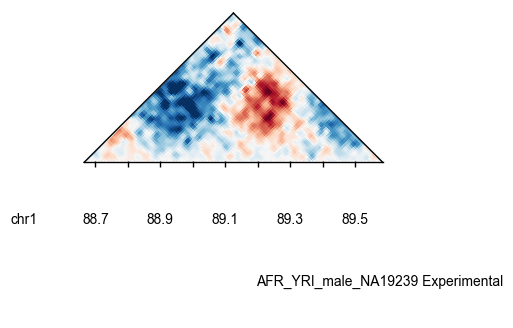

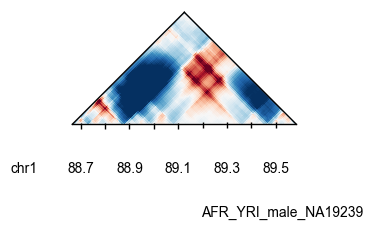

AFR_YRI_male_NA19239 0.8275261589497364
EAS_CHS_female_HG00513
1/1 [==============================] - 1s 1s/step


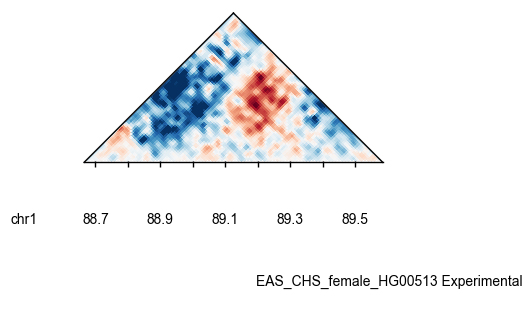

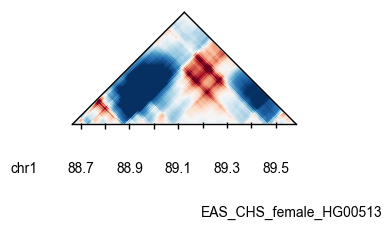

EAS_CHS_female_HG00513 0.8128073667362603
AMR_PUR_male_HG00731
1/1 [==============================] - 1s 1s/step


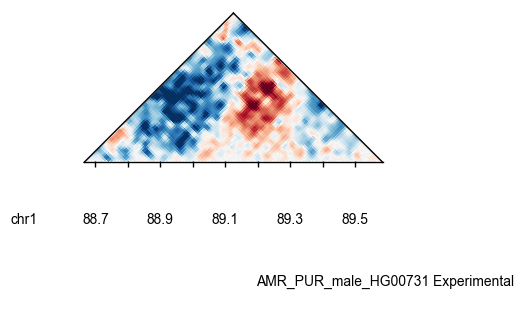

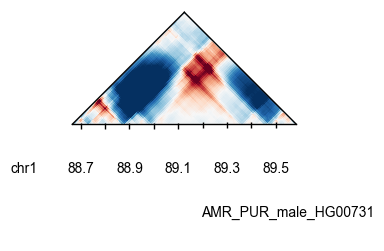

AMR_PUR_male_HG00731 0.7631743325816135
AMR_PUR_female_HG00732
1/1 [==============================] - 1s 1s/step


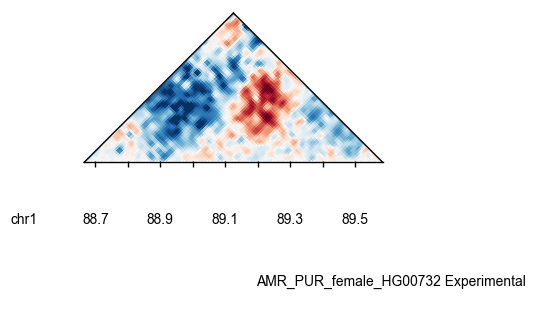

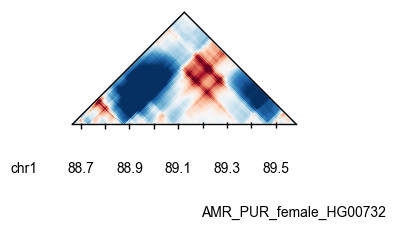

AMR_PUR_female_HG00732 0.7754279914410372


In [123]:
chrm = 'chr1'
wndw = 88604672
resolution = 10000
for ind in exp_indivs.full_name:
    print(ind)
    spear = exp_pred_comp(ind, chrm, wndw, sat=1)
    print(ind, spear)

# IDWs

In [245]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % RESULTS_PATH,
                       index_col=0)
all_indivs = sorted(list(set(comp_list.ind1.unique()) | set(comp_list.ind2.unique())))
feng_indivs = ['NA12763', 'HG01982', 'HG00318', 'HG01198']

In [339]:
feng_indivs = ['NA12763', 'HG01982', 'HG00318', 'HG01198']
list(anc[anc.id.isin(feng_indivs)].full_name)

['AMR_PEL_male_HG01982',
 'AMR_PUR_female_HG01198',
 'EUR_CEU_female_NA12763',
 'EUR_FIN_female_HG00318']

In [340]:
list(set(all_indivs) & set(list(anc[anc.id.isin(feng_indivs)].full_name)))

['AMR_PUR_female_HG01198']

In [333]:
all_indivs

['AFR_ACB_female_HG01896',
 'AFR_ACB_female_HG02095',
 'AFR_ACB_female_HG02337',
 'AFR_ACB_female_HG02505',
 'AFR_ACB_female_HG02555',
 'AFR_ASW_female_NA19625',
 'AFR_ASW_female_NA19901',
 'AFR_ASW_female_NA19917',
 'AFR_ASW_female_NA20314',
 'AFR_ASW_female_NA20317',
 'AFR_ESN_female_HG02946',
 'AFR_ESN_female_HG02974',
 'AFR_ESN_female_HG03111',
 'AFR_ESN_female_HG03159',
 'AFR_ESN_female_HG03511',
 'AFR_GWD_female_HG02635',
 'AFR_GWD_female_HG02679',
 'AFR_GWD_female_HG02814',
 'AFR_GWD_female_HG02879',
 'AFR_GWD_female_HG02888',
 'AFR_LWK_female_NA19024',
 'AFR_LWK_female_NA19037',
 'AFR_LWK_female_NA19314',
 'AFR_LWK_female_NA19446',
 'AFR_LWK_female_NA19457',
 'AFR_MSL_female_HG03086',
 'AFR_MSL_female_HG03378',
 'AFR_MSL_female_HG03458',
 'AFR_MSL_female_HG03575',
 'AFR_MSL_female_HG03583',
 'AFR_YRI_female_NA19116',
 'AFR_YRI_female_NA19129',
 'AFR_YRI_female_NA19137',
 'AFR_YRI_female_NA19172',
 'AFR_YRI_female_NA19206',
 'AMR_CLM_female_HG01125',
 'AMR_CLM_female_HG01366',
 

In [251]:
list(set(all_indivs) & set(exp_indivs.full_name))

[]

In [344]:
idw_list = pd.read_table("%s/IDWs/idw_mut_params.txt" % DATA_PATH, names = ['chr','window_start','window_end','individual', 'depth'])

In [346]:
idw_list

chr  window_start  window_end              individual     depth
121   chr1       3670016     4718592  AFR_ASW_female_NA19901  0.016704
115   chr1       6291456     7340032  AFR_ASW_female_NA19625  0.003675
87    chr1       7340032     8388608  SAS_BEB_female_HG04183  0.002926
72    chr1      10485760    11534336  AFR_MSL_female_HG03575  0.019718
72    chr1      11010048    12058624  AFR_MSL_female_HG03575  0.050779
..     ...           ...         ...                     ...       ...
78   chr22      40894464    41943040  SAS_STU_female_HG03673  0.009164
26   chr22      43515904    44564480  AMR_PUR_female_HG01326  0.011355
62   chr22      44564480    45613056  AFR_GWD_female_HG02879  0.025806
54   chr22      45613056    46661632  AFR_ACB_female_HG02555  0.022792
78   chr22      47185920    48234496  SAS_STU_female_HG03673  0.328717

[1251 rows x 5 columns]

In [347]:
idw_list[idw_list.individual.isin(list(anc[anc.id.isin(feng_indivs)].full_name))]

chr  window_start  window_end              individual     depth
25   chr3      64487424    65536000  AMR_PUR_female_HG01198  0.004033
25   chr3      98041856    99090432  AMR_PUR_female_HG01198  0.015840
25   chr4     151519232   152567808  AMR_PUR_female_HG01198  0.013396
25   chr8      98041856    99090432  AMR_PUR_female_HG01198  0.004113
25   chr9      16777216    17825792  AMR_PUR_female_HG01198  0.004521
25  chr17        524288     1572864  AMR_PUR_female_HG01198  0.006671
25  chr17       1048576     2097152  AMR_PUR_female_HG01198  0.012512
25  chr21      29360128    30408704  AMR_PUR_female_HG01198  0.029085

In [326]:
idws = rho.loc[list(zip(idw_list.vcf_col_id, idw_list.chr))]
idws['avg'] = idws.mean(axis=1)
idws['max'] = idws.max(axis=1)
idws['depth'] = np.array(idw_list['individual'])
idws[idws['max'] > 0.5][idws.depth > 0.1].sort_values(by=['depth'], ascending=False).head(n=10)

AFR                                          \
                           YRI                                           
                          male              female      male    female   
                       NA18516   NA18522   NA19099   NA19141   NA19204   
chr   windowStartPos                                                     
chr14 46137344        0.349753  0.370786  0.345696  0.394568  0.291716   
chr1  104333312       0.192462  0.540893  0.219613  0.327342  0.404287   
chr10 66060288        0.318598  0.370080  0.367299  0.367333  0.406045   
chr2  153092096       0.555435  0.447308  0.523986  0.440173  0.502232   
chr3  165150720       0.145743  0.364152  0.241325  0.318651  0.433019   
chr4  175112192       0.329573  0.424283  0.395029  0.486455  0.426224   
chr21 17825792        0.223100  0.272460  0.273291  0.367853  0.191162   
chr4  48234496        0.599417  0.604271  0.558198  0.596821  0.554229   
chr6  144703488       0.414085  0.496175  0.473347  0.541600  0.529566   
chr9  31457280        0.480157  0.529902  0.554018  0.603562  0.646573   

                                               EAS       AMR            \
                                               CHS       PUR             
                                    male    female      male    female   
                       NA19238   NA19239   HG00513   HG00731   HG00732   
chr   windowStartPos                                                     
chr14 46137344        0.321374  0.239903  0.300420  0.220046  0.181108   
chr1  104333312       0.129048  0.194329  0.229267  0.059855  0.251550   
chr10 66060288        0.376953  0.541038  0.274612  0.161413  0.270409   
chr2  153092096       0.447758  0.584706  0.409738  0.354359  0.432385   
chr3  165150720       0.241572  0.010844  0.289553  0.207450  0.104169   
chr4  175112192       0.308999  0.298197  0.311477  0.271041  0.181227   
chr21 17825792        0.282011  0.235508  0.319292  0.206498  0.199980   
chr4  48234496        0.596722  0.540036  0.538977  0.512865  0.565586   
chr6  144703488       0.454734  0.461194  0.482905  0.336333  0.308841   
chr9  31457280        0.543149  0.561223  0.467784  0.393172  0.339249   

                           EUR       AFR                                \
                           CEU       YRI                                 
                        female      male    female      male    female   
                       NA12878   NA18486   NA18505   NA18507   NA18508   
chr   windowStartPos                                                     
chr14 46137344        0.554481  0.446724  0.315071  0.188449  0.166993   
chr1  104333312       0.428730  0.177468  0.244141  0.324955  0.176140   
chr10 66060288        0.431620  0.341369  0.367400  0.436556  0.395377   
chr2  153092096       0.552737  0.463052  0.461660  0.489439  0.495015   
chr3  165150720       0.546005  0.323563  0.376292  0.126898  0.023614   
chr4  175112192       0.531109  0.457031  0.439466  0.346618  0.312047   
chr21 17825792        0.507341  0.301634  0.277514  0.145551  0.378126   
chr4  48234496        0.610640  0.588637  0.574582  0.572547  0.580395   
chr6  144703488       0.542502  0.451531  0.414956  0.423560  0.483401   
chr9  31457280        0.572480  0.460612  0.428413  0.523351  0.414816   

                           avg       max     depth  
                                                    
                                                    
                                                    
chr   windowStartPos                                
chr14 46137344        0.312473  0.554481  0.444698  
chr1  104333312       0.260005  0.540893  0.316660  
chr10 66060288        0.361740  0.541038  0.311831  
chr2  153092096       0.477332  0.584706  0.244319  
chr3  165150720       0.250190  0.546005  0.203395  
chr4  175112192       0.367918  0.531109  0.188100  
chr21 17825792        0.278755  0.507341  0.141715  
chr4  48234496        0.572928  0.610640  0.134993  
chr6 

1/1 [==============================] - 1s 1s/step


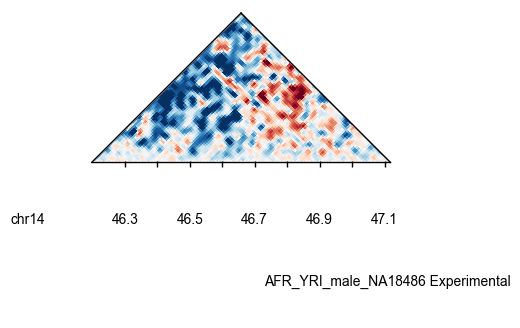

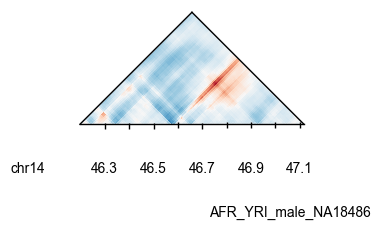

1/1 [==============================] - 1s 1s/step


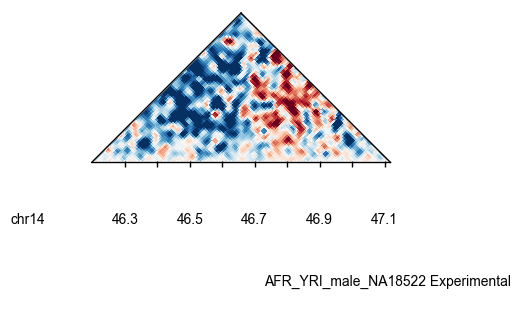

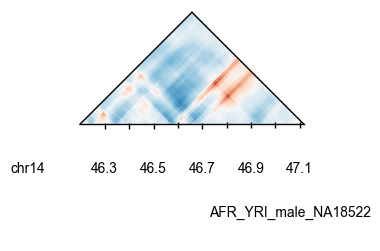

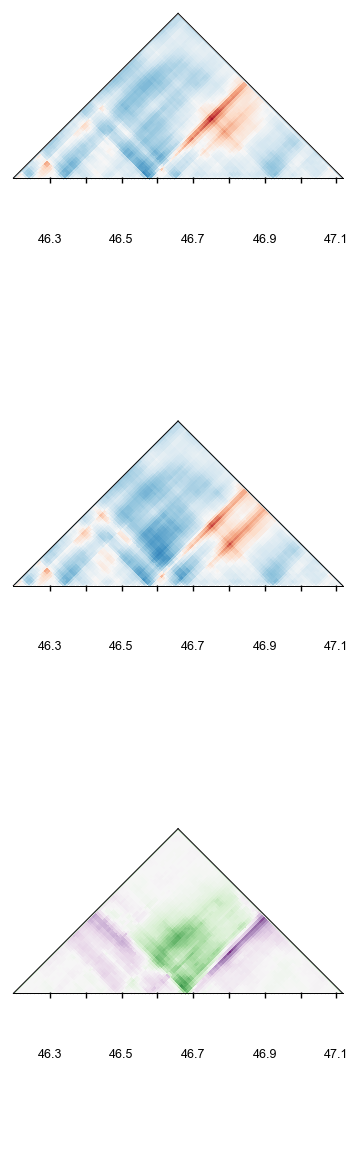

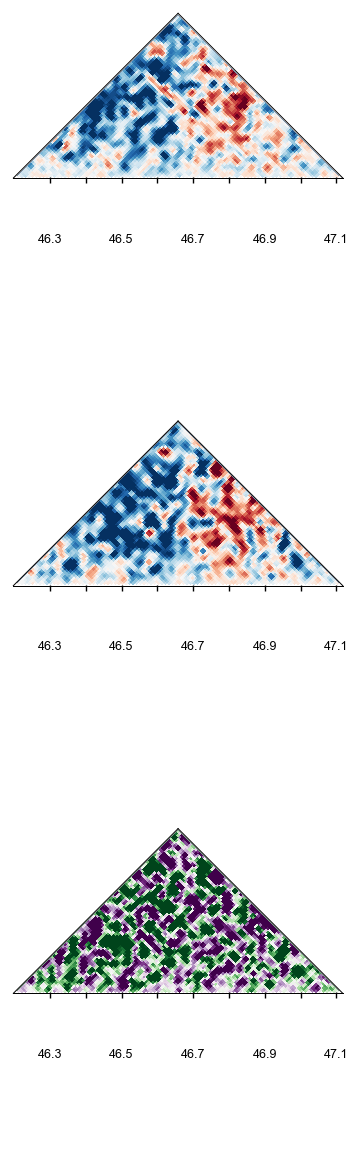

In [331]:
chrm = 'chr14'
wndw = 46137344
sat = .5

resolution = 10000

for ind in exp_indivs.full_name:
    accession_ind = exp_indivs[exp_indivs.full_name==ind].accession.values[0]
    # genome_hic_cool_ind = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_ind, resolution))
    # exp_target_ind = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_ind, resolution)

    ind_seq_ind = get_seq(chrm, wndw, ind)
    ind_pred_ind = runAkitaPreds(ind_seq_ind)

    ind_mat = from_upper_triu(ind_pred_ind, 448, 2)
    ind_mat_compressed = ski.transform.resize(ind_mat, (nbins,nbins), anti_aliasing=False)
    #rho, p = stats.spearmanr(exp_target_ind, ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)])

    # exp = visualize_map_exp(exp_target_ind,ind, wndw, chrm, s=nbins, res=resolution, cbar=False, sat = sat)
    pred = visualize_map_compressed(ind_pred_ind, wndw, ind, chrm, s=nbins, res=resolution, sat = sat)

# ind1 = 'AFR_YRI_male_NA18486'
# ind2 = 'AFR_YRI_male_NA18522'

# nbins = 92

# spear1, exp1, pred1 = exp_pred_comp(ind1, chrm, wndw, sat=sat, nbins=nbins, resolution = resolution)
# spear2, exp2, pred2 = exp_pred_comp(ind2, chrm, wndw, sat=sat, nbins = nbins, resolution = resolution)

# simple_map_comparison(pred1, pred2, chrm, wndw, s=nbins, res = resolution, sat = sat)
# simple_map_comparison(exp1, exp2, chrm, wndw, s = nbins, res = resolution, sat = sat)



1/1 [==============================] - 1s 1s/step


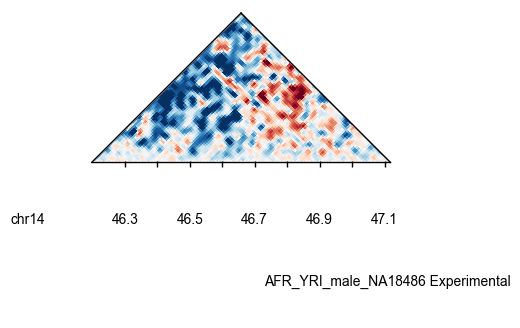

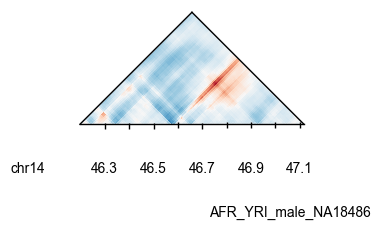

1/1 [==============================] - 1s 1s/step


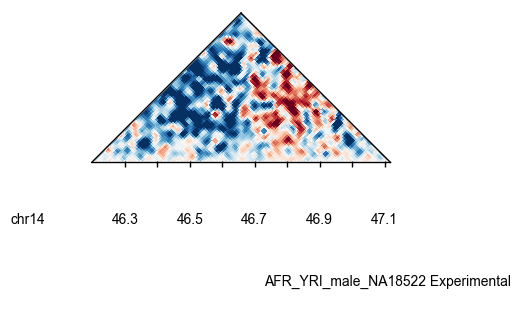

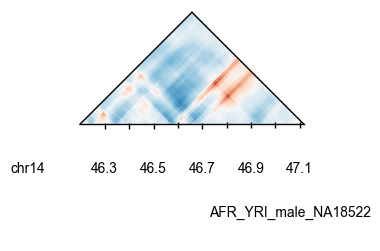

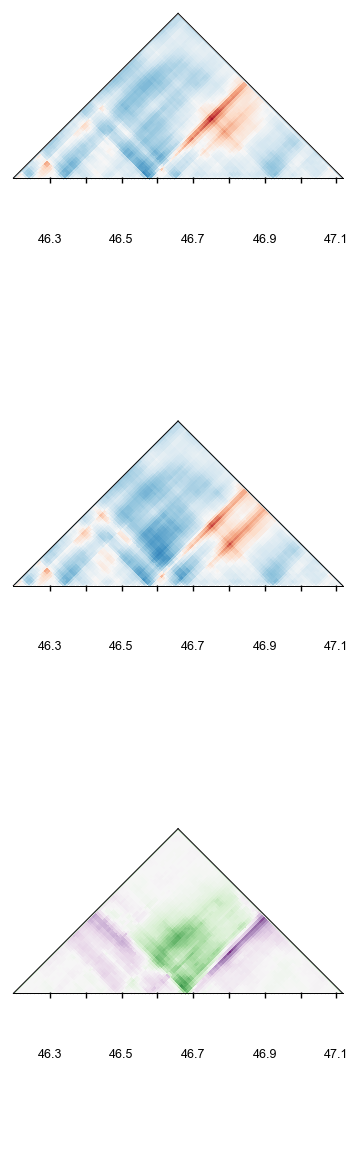

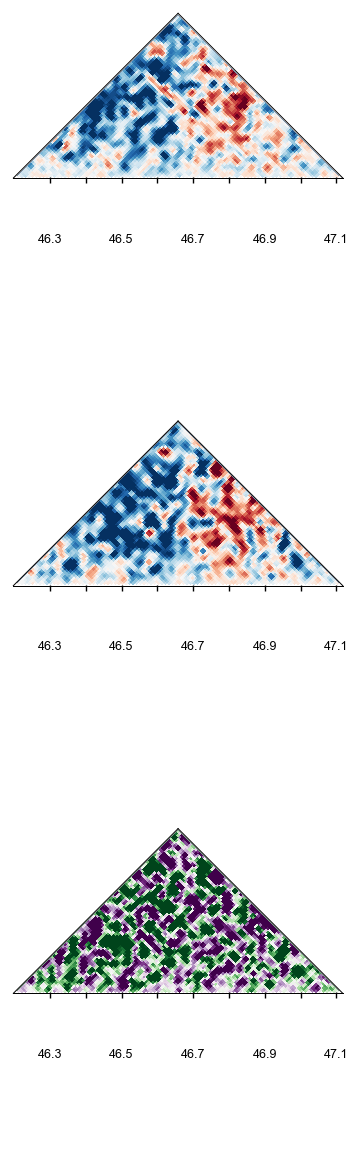

In [332]:
chrm = 'chr14'
wndw = 46137344
sat = .5

resolution = 10000

# for ind in exp_indivs.full_name:
#     accession_ind = exp_indivs[exp_indivs.full_name==ind].accession.values[0]
#     # genome_hic_cool_ind = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_ind, resolution))
#     # exp_target_ind = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_ind, resolution)

#     ind_seq_ind = get_seq(chrm, wndw, ind)
#     ind_pred_ind = runAkitaPreds(ind_seq_ind)

#     ind_mat = from_upper_triu(ind_pred_ind, 448, 2)
#     ind_mat_compressed = ski.transform.resize(ind_mat, (nbins,nbins), anti_aliasing=False)
#     #rho, p = stats.spearmanr(exp_target_ind, ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)])

#     # exp = visualize_map_exp(exp_target_ind,ind, wndw, chrm, s=nbins, res=resolution, cbar=False, sat = sat)
#     pred = visualize_map_compressed(ind_pred_ind, wndw, ind, chrm, s=nbins, res=resolution, sat = sat)

ind1 = 'AFR_YRI_male_NA18486'
ind2 = 'AFR_YRI_male_NA18522'
chrm = 'chr14'
wndw = 46137344
sat = .5
resolution = 10000
nbins = 92

spear1, exp1, pred1 = exp_pred_comp(ind1, chrm, wndw, sat=sat, nbins=nbins, resolution = resolution)
spear2, exp2, pred2 = exp_pred_comp(ind2, chrm, wndw, sat=sat, nbins = nbins, resolution = resolution)

simple_map_comparison(pred1, pred2, chrm, wndw, s=nbins, res = resolution, sat = sat)
simple_map_comparison(exp1, exp2, chrm, wndw, s = nbins, res = resolution, sat = sat)



# Heldout set

In [34]:

def one_indiv_comps(accession, resolution=10000, nbins=92):
    ind = exp_indivs[exp_indivs['accession']==accession]['full_name'].values[0]

    genome_hic_cool = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession, resolution))

    file_dict = {}
    with open('/wynton/group/capra/projects/modern_human_3Dgenome/data/akitaPreds/3dpreds/HFF_original/3dpreds_%s.txt' % (ind)) as file:
        lines1 = file.readlines()
        for i in range(len(lines1)):
            l1 = lines1[i]
            indiv1 = l1.strip().split("\t")
            indiv1_chr = indiv1[0]
            indiv1_pos = int(indiv1[1])
            indiv1 = list(map(float,indiv1[2:]))
            file_dict[(indiv1_chr, indiv1_pos)] = indiv1

    
    rhos = {}
    mses = {}
    counter = 0
    for chrm, wndw in list(zip(windows_to_keep.chr, windows_to_keep.windowStartPos)):
        keyi = (chrm, wndw)
        if counter % 100 == 0:
            print("%s out of 4873" % counter)
        try:
            exp_target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool, resolution)
            #exp_mat = from_upper_triu(exp_target, nbins, 2)

            ind_pred = file_dict[keyi]
            ind_mat = from_upper_triu(ind_pred, 448, 2)
            ind_mat_compressed = ski.transform.resize(ind_mat, (nbins,nbins), anti_aliasing=False)
            
            rho, p = stats.spearmanr(exp_target, ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)])
            rhos[keyi] = rho

            mse = np.mean(np.square(exp_target - ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)]))
            mses[keyi] = mse
        except:
            rhos[keyi] = np.NaN
            mses[keyi] = np.NaN

        counter += 1

    return mses, rhos

In [35]:
# comp_data = {}
# for accession in accessions:
#     mses, rhos = one_indiv_comps_held_out(accession)
#     ind = exp_indivs[exp_indivs['accession']==accession]['full_name'].values[0]

#     comp_data[ind] = mses, rhos

# comp_dfs = dict.fromkeys(comp_data.keys())
# for k in comp_data.keys():
#     a = pd.DataFrame.from_dict(comp_data[k][0], orient='index')
#     b = pd.DataFrame.from_dict(comp_data[k][1], orient='index')
#     c = pd.concat([a,b], axis=1)
#     c.columns = ['mse','rho']
#     comp_dfs[k] = c

# comps_df = pd.concat(comp_dfs, axis=1)
# mse = comps_df.swaplevel(0,1, axis=1)['mse']
# rho = comps_df.swaplevel(0,1, axis=1)['rho']
# mse.columns = mse.columns.str.split('_', expand=True)
# rho.columns = rho.columns.str.split('_', expand=True)

# mse.to_csv('%s/intermediates/experimental_vs_predicted_held_out_mse.csv' % DATA_PATH)
# rho.to_csv('%s/intermediates/experimental_vs_predicted_held_out_rho.csv' % DATA_PATH)

mse = pd.read_csv('%s/intermediates/experimental_vs_predicted_held_out_mse.csv' % DATA_PATH, header=[0,1,2,3], index_col=0)
rho = pd.read_csv('%s/intermediates/experimental_vs_predicted_held_out_rho.csv' % DATA_PATH, header=[0,1,2,3], index_col=0)

In [36]:
rho_avg = rho.mean()
exp_indivs['average_rho'] = rho_avg.values

In [37]:
exp_indivs

accession       id  filtered_reads          ancestor  genome_avg_mse  \
0   4DNFIL76YMY6  NA12878         3410.00  hsmrca_ancestral        0.000665   
1   4DNFI7N72M2A  NA18486          536.91  hsmrca_ancestral        0.000687   
2   4DNFIIDNWL5I  NA18505          356.06  hsmrca_ancestral        0.000684   
3   4DNFIEYSPGU1  NA18507          447.26  hsmrca_ancestral        0.000668   
4   4DNFI6SJZVXZ  NA18508          378.32  hsmrca_ancestral        0.000682   
5   4DNFIOF2U3HX  NA18516          358.07  hsmrca_ancestral        0.000717   
6   4DNFI2Y6GTWP  NA18522          292.44  hsmrca_ancestral        0.000646   
7   4DNFIKAC7MSF  NA19099          539.80  hsmrca_ancestral        0.000680   
8   4DNFIKMV9ZC7  NA19141          357.86  hsmrca_ancestral        0.000706   
9   4DNFI78T9N5Y  NA19204          535.11  hsmrca_ancestral        0.000663   
10  4DNFIIRNP38T  NA19238          464.03  hsmrca_ancestral        0.000662   
11  4DNFIO7M1D22  NA19239          468.57  hsmrca_ancestral        0.000685   
12  4DNFI66KARTU  HG00513          352.17  hsmrca_ancestral        0.000656   
13  4DNFIUZJP1ED  HG00731          319.74  hsmrca_ancestral        0.000659   
14  4DNFIFXDDDJ6  HG00732          381.71  hsmrca_ancestral        0.000658   

    genome_avg_spearman super_pop sub_pop     sex  divergence  \
0              0.995854       EUR     CEU  female    0.004146   
1              0.995574       AFR     YRI    male    0.004426   
2              0.995434       AFR     YRI  female    0.004566   
3              0.995687       AFR     YRI    male    0.004313   
4              0.995677       AFR     YRI  female    0.004323   
5              0.995268       AFR     YRI    male    0.004732   
6              0.995555       AFR     YRI    male    0.004445   
7              0.995421       AFR     YRI  female    0.004579   
8              0.995345       AFR     YRI    male    0.004655   
9              0.995752       AFR     YRI  female    0.004248   
10             0.995472       AFR     YRI  female    0.004528   
11             0.995384       AFR     YRI    male    0.004616   
12             0.995674       EAS     CHS  female    0.004326   
13             0.995709       AMR     PUR    male    0.004291   
14             0.995828       AMR     PUR  female    0.004172   

                 full_name  average_rho  
0   EUR_CEU_female_NA12878     0.478733  
1     AFR_YRI_male_NA18486     0.435471  
2   AFR_YRI_female_NA18505     0.412088  
3     AFR_YRI_male_NA18507     0.427924  
4   AFR_YRI_female_NA18508     0.400902  
5     AFR_YRI_male_NA18516     0.409660  
6     AFR_YRI_male_NA18522     0.440172  
7   AFR_YRI_female_NA19099     0.439021  
8     AFR_YRI_male_NA19141     0.463583  
9   AFR_YRI_female_NA19204     0.439031  
10  AFR_YRI_female_NA19238     0.427630  
11    AFR_YRI_male_NA19239     0.419338  
12  EAS_CHS_female_HG00513     0.369693  
13    AMR_PUR_male_HG00731     0.352235  
14  AMR_PUR_female_HG00732     0.361021

<Axes: xlabel='genome_avg_spearman', ylabel='average_rho'>

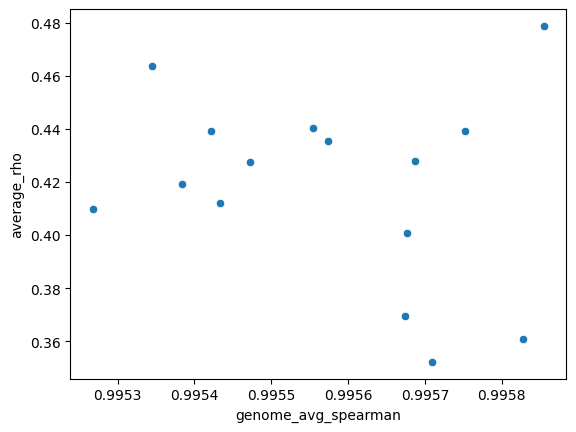

In [38]:
sns.scatterplot(x = 'genome_avg_spearman', y = 'average_rho', data = exp_indivs)

0.5029379795137854 0.2529466112374088 0.05601318699731627


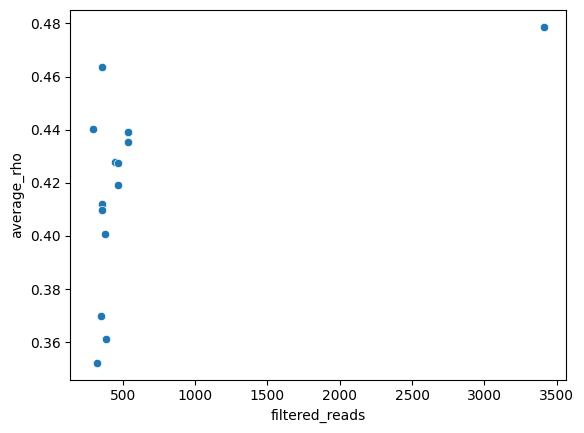

In [16]:

sns.scatterplot(x='filtered_reads', y = 'average_rho', data = exp_indivs)
plt.savefig('results/plots/experimental_reads_to_accuracy.svg', bbox_inches = 'tight')
slope, intercept, r, p, se = stats.linregress(exp_indivs['filtered_reads'].values, exp_indivs['average_rho'].values)
print(r, r**2, p)

In [17]:
stats.spearmanr(exp_indivs['filtered_reads'].values, exp_indivs['average_rho'].values)

SignificanceResult(statistic=0.4392857142857142, pvalue=0.10136057119347243)

0.428857072510496 0.1839183886422728 0.12599378878779305


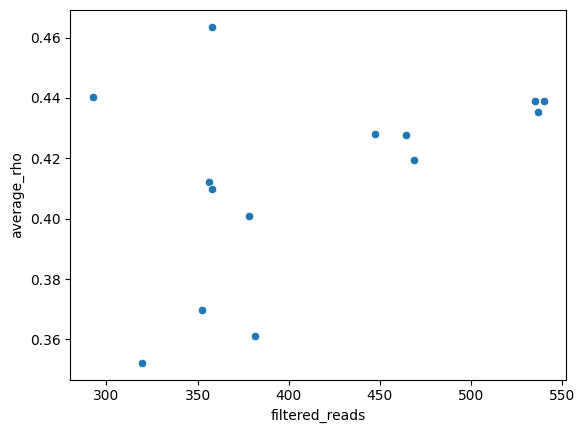

In [18]:
sns.scatterplot(x='filtered_reads', y = 'average_rho', data = exp_indivs.drop(index=[0]))
plt.savefig('results/plots/experimental_reads_to_accuracy_zoom.svg', bbox_inches = 'tight')
slope, intercept, r, p, se = stats.linregress(exp_indivs.drop(index=[0])['filtered_reads'].values, exp_indivs.drop(index=[0])['average_rho'].values)
print(r, r**2, p)

0.2529466112374088 0.05601318699731627


In [434]:

print(r**2, p)

0.1839183886422728 0.12599378878779305


In [426]:
exp_indivs.drop(index=[0])

accession       id  filtered_reads          ancestor  genome_avg_mse  \
1   4DNFI7N72M2A  NA18486          536.91  hsmrca_ancestral        0.000687   
2   4DNFIIDNWL5I  NA18505          356.06  hsmrca_ancestral        0.000684   
3   4DNFIEYSPGU1  NA18507          447.26  hsmrca_ancestral        0.000668   
4   4DNFI6SJZVXZ  NA18508          378.32  hsmrca_ancestral        0.000682   
5   4DNFIOF2U3HX  NA18516          358.07  hsmrca_ancestral        0.000717   
6   4DNFI2Y6GTWP  NA18522          292.44  hsmrca_ancestral        0.000646   
7   4DNFIKAC7MSF  NA19099          539.80  hsmrca_ancestral        0.000680   
8   4DNFIKMV9ZC7  NA19141          357.86  hsmrca_ancestral        0.000706   
9   4DNFI78T9N5Y  NA19204          535.11  hsmrca_ancestral        0.000663   
10  4DNFIIRNP38T  NA19238          464.03  hsmrca_ancestral        0.000662   
11  4DNFIO7M1D22  NA19239          468.57  hsmrca_ancestral        0.000685   
12  4DNFI66KARTU  HG00513          352.17  hsmrca_ancestral        0.000656   
13  4DNFIUZJP1ED  HG00731          319.74  hsmrca_ancestral        0.000659   
14  4DNFIFXDDDJ6  HG00732          381.71  hsmrca_ancestral        0.000658   

    genome_avg_spearman super_pop sub_pop     sex  divergence  \
1              0.995574       AFR     YRI    male    0.004426   
2              0.995434       AFR     YRI  female    0.004566   
3              0.995687       AFR     YRI    male    0.004313   
4              0.995677       AFR     YRI  female    0.004323   
5              0.995268       AFR     YRI    male    0.004732   
6              0.995555       AFR     YRI    male    0.004445   
7              0.995421       AFR     YRI  female    0.004579   
8              0.995345       AFR     YRI    male    0.004655   
9              0.995752       AFR     YRI  female    0.004248   
10             0.995472       AFR     YRI  female    0.004528   
11             0.995384       AFR     YRI    male    0.004616   
12             0.995674       EAS     CHS  female    0.004326   
13             0.995709       AMR     PUR    male    0.004291   
14             0.995828       AMR     PUR  female    0.004172   

                 full_name  average_rho  
1     AFR_YRI_male_NA18486     0.435471  
2   AFR_YRI_female_NA18505     0.412088  
3     AFR_YRI_male_NA18507     0.427924  
4   AFR_YRI_female_NA18508     0.400902  
5     AFR_YRI_male_NA18516     0.409660  
6     AFR_YRI_male_NA18522     0.440172  
7   AFR_YRI_female_NA19099     0.439021  
8     AFR_YRI_male_NA19141     0.463583  
9   AFR_YRI_female_NA19204     0.439031  
10  AFR_YRI_female_NA19238     0.427630  
11    AFR_YRI_male_NA19239     0.419338  
12  EAS_CHS_female_HG00513     0.369693  
13    AMR_PUR_male_HG00731     0.352235  
14  AMR_PUR_female_HG00732     0.361021

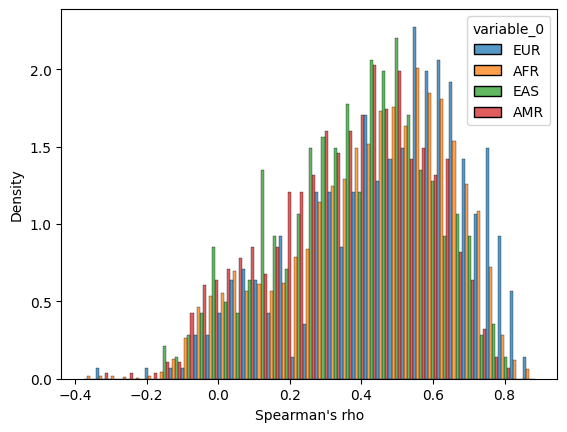

In [91]:
rho.melt()
sns.histplot(data=rho.melt(), x = 'value', hue = 'variable_0', stat = 'density', common_norm = False, multiple='dodge')
plt.xlabel("Spearman's rho")
plt.savefig('results/plots/experimental_correlations.svg', bbox_inches = 'tight')

In [27]:
rho['AMR'].mean().mean()

0.3566278200983659

In [26]:
rho['EUR'].mean().mean()

0.4787334353986281

In [25]:
rho['EAS'].mean().mean()

0.3696934412675416

In [23]:
rho['AFR'].mean().mean()

0.4286199986178448

In [386]:
np.ones(len(rho.melt())) / len(rho.melt())

array([0.00016142, 0.00016142, 0.00016142, ..., 0.00016142, 0.00016142,
       0.00016142])

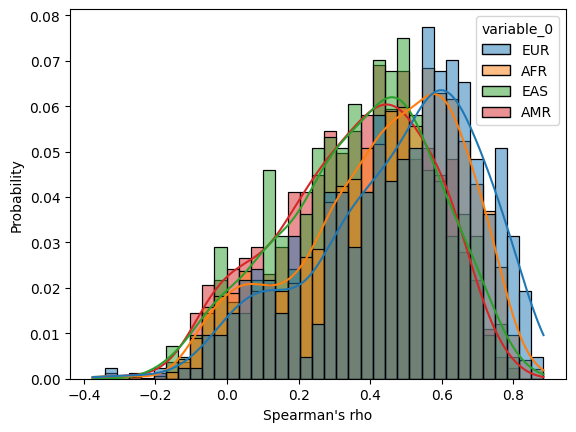

In [397]:
rho.melt()
sns.histplot(data=rho.melt(), x = 'value', hue = 'variable_0', common_norm = False, stat = 'probability' , kde=True, )
plt.xlabel("Spearman's rho")
plt.savefig('results/plots/experimental_correlations_kde.svg', bbox_inches = 'tight')

<Axes: xlabel='value', ylabel='Probability'>

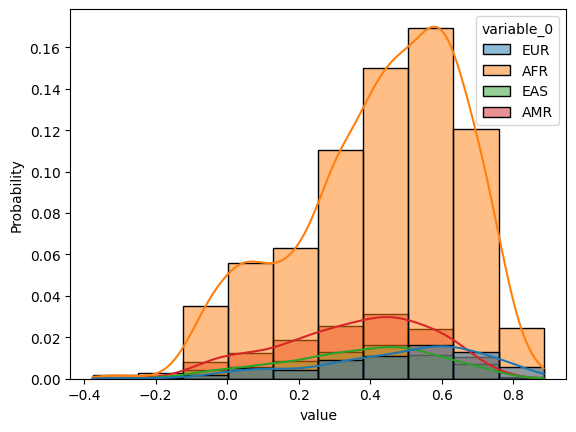

In [378]:
sns.histplot(data=rho.melt(), x = 'value', hue = 'variable_0', kde=True, stat="probability", color="r", label="probabilities", common_norm = True, weights=np.ones(len(rho.melt())) / len(rho.melt()))

<Axes: xlabel='value', ylabel='Probability'>

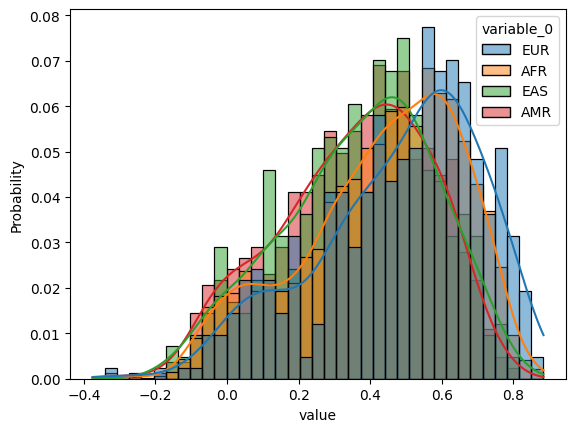

In [374]:
sns.histplot(data=rho.melt(), x = 'value', hue = 'variable_0', kde=True, stat="probability", color="r", label="probabilities", common_norm = False)


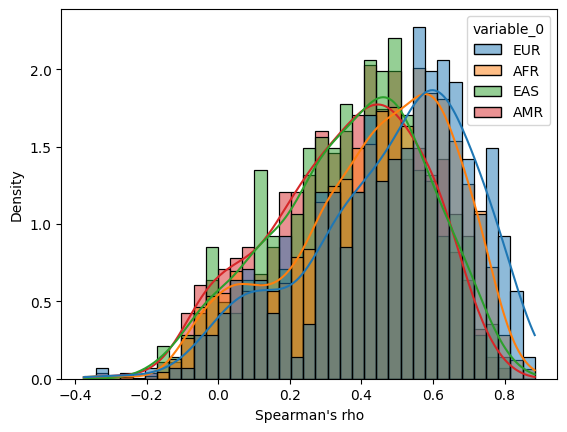

In [90]:
rho.melt()
sns.histplot(data=rho.melt(), x = 'value', hue = 'variable_0', stat = 'density', common_norm = False, kde=True)
plt.xlabel("Spearman's rho")
plt.savefig('results/plots/experimental_correlations.svg', bbox_inches = 'tight')

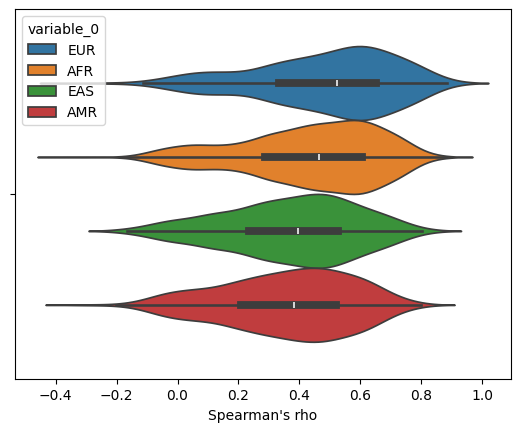

In [19]:
rho.melt()
sns.violinplot(data=rho.melt(), x = 'value', hue = 'variable_0')
plt.xlabel("Spearman's rho")
plt.savefig('results/plots/experimental_correlations_violin.svg', bbox_inches = 'tight')

In [132]:
rho_melt

variable_0 variable_1 variable_2 variable_3     value
(chr9, 135012352)        EUR        CEU     female    NA12878  0.377345
(chr1, 188526592)        EUR        CEU     female    NA12878  0.095549
(chr6, 115486720)        EUR        CEU     female    NA12878  0.490284
(chr10, 83025920)        EUR        CEU     female    NA12878  0.183904
(chr6, 156624896)        EUR        CEU     female    NA12878  0.740108
...                      ...        ...        ...        ...       ...
(chr7, 37795840)         AMR        PUR     female    HG00732  0.563605
(chr19, 13506560)        AMR        PUR     female    HG00732  0.065844
(chr7, 21473280)         AMR        PUR     female    HG00732  0.634278
(chr4, 56834048)         AMR        PUR     female    HG00732  0.533538
(chr10, 85123072)        AMR        PUR     female    HG00732  0.058644

[6195 rows x 5 columns]

In [137]:
kruskal = stats.kruskal(rho_melt[rho_melt['variable_0']=='AFR']['value'], 
            rho_melt[rho_melt['variable_0']=='EUR']['value'],
            rho_melt[rho_melt['variable_0']=='AMR']['value'],
            rho_melt[rho_melt['variable_0']=='EAS']['value'],)
conover = sp.posthoc_conover(rho_melt, val_col='value', group_col='variable_0', p_adjust = 'holm')

In [134]:
kruskal

KruskalResult(statistic=141.2540185366015, pvalue=2.0279751566025264e-30)

In [138]:
conover

AFR           AMR           EAS           EUR
AFR  1.000000e+00  1.199765e-19  2.284858e-08  1.165151e-05
AMR  1.199765e-19  1.000000e+00  3.744159e-01  2.849794e-21
EAS  2.284858e-08  3.744159e-01  1.000000e+00  1.142224e-13
EUR  1.165151e-05  2.849794e-21  1.142224e-13  1.000000e+00

In [128]:
rho_melt = rho.melt(ignore_index=False)
rho_melt[rho_melt.value>0.87]

variable_0 variable_1 variable_2 variable_3     value
(chr12, 102830080)        EUR        CEU     female    NA12878  0.883185
(chr8, 123740160)         EUR        CEU     female    NA12878  0.871779
(chr12, 102830080)        AFR        YRI       male    NA18486  0.877761
(chr12, 102830080)        AFR        YRI     female    NA19099  0.884372
(chr8, 123740160)         AFR        YRI       male    NA19141  0.875280
(chr12, 102830080)        AFR        YRI       male    NA19239  0.881786

1/1 [==============================] - 1s 787ms/step


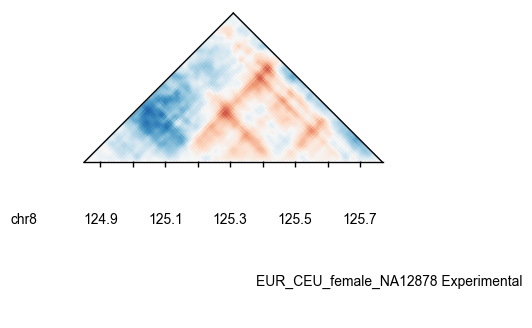

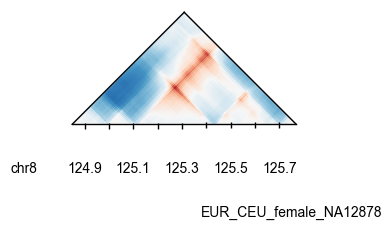

1/1 [==============================] - 1s 785ms/step


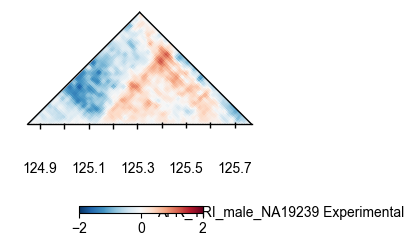

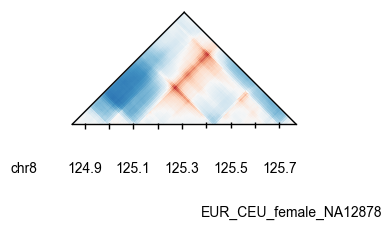

In [144]:
eur = 'EUR_CEU_female_NA12878'
afr = 'AFR_YRI_male_NA19239'
chrm = 'chr8'
wndw = 124788736

accession_eur = exp_indivs[exp_indivs.full_name==eur].accession.values[0]
genome_hic_cool_eur = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_eur, resolution))
exp_target_eur = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_eur, resolution)

ind_seq_eur = get_seq(chrm, wndw, eur)
ind_pred_eur = runAkitaPreds(ind_seq_eur)

_ = visualize_map_exp(exp_target_eur,eur, wndw, chrm, s=92, res=resolution, cbar=False, sat = 2)
_ = visualize_map_compressed(ind_pred_eur, wndw, eur, chrm, s=92, res=resolution, sat=2)

accession_afr = exp_indivs[exp_indivs.full_name==afr].accession.values[0]
genome_hic_cool_afr = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_afr, resolution))
exp_target_afr = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_afr, resolution)

ind_seq_afr = get_seq(chrm, wndw, afr)
ind_pred_afr = runAkitaPreds(ind_seq_afr)

_ = visualize_map_exp(exp_target_afr, afr, wndw, chrm, s=92, res=resolution, cbar=True, sat = 2)
_ = visualize_map_compressed(ind_pred_afr, wndw, eur, chrm, s=92, res=resolution, sat=2)


1/1 [==============================] - 1s 791ms/step


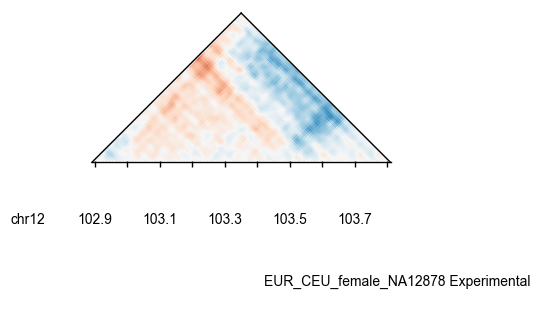

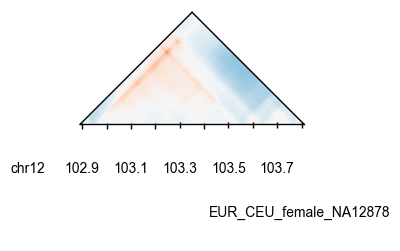

1/1 [==============================] - 1s 771ms/step


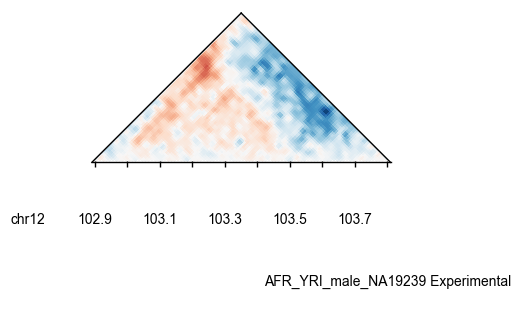

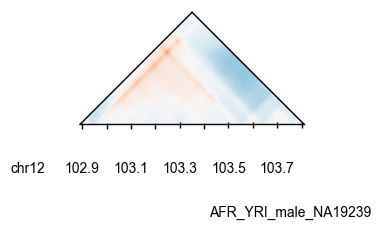

In [141]:
eur = 'EUR_CEU_female_NA12878'
afr = 'AFR_YRI_male_NA19239'
chrm = 'chr12'
wndw = 102830080

accession_eur = exp_indivs[exp_indivs.full_name==eur].accession.values[0]
genome_hic_cool_eur = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_eur, resolution))
exp_target_eur = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_eur, resolution)

ind_seq_eur = get_seq(chrm, wndw, eur)
ind_pred_eur = runAkitaPreds(ind_seq_eur)

_ = visualize_map_exp(exp_target_eur,eur, wndw, chrm, s=92, res=resolution, cbar=False, sat = 2)
_ = visualize_map_compressed(ind_pred_eur, wndw, eur, chrm, s=92, res=resolution, sat=2)

accession_afr = exp_indivs[exp_indivs.full_name==afr].accession.values[0]
genome_hic_cool_afr = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_afr, resolution))
exp_target_afr = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_afr, resolution)

ind_seq_afr = get_seq(chrm, wndw, afr)
ind_pred_afr = runAkitaPreds(ind_seq_afr)

_ = visualize_map_exp(exp_target_afr, afr, wndw, chrm, s=92, res=resolution, cbar=False, sat = 2)
_ = visualize_map_compressed(ind_pred_afr, wndw, afr, chrm, s=92, res=resolution, sat=2)


1/1 [==============================] - 1s 791ms/step


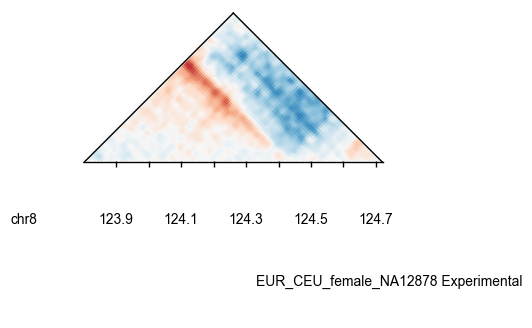

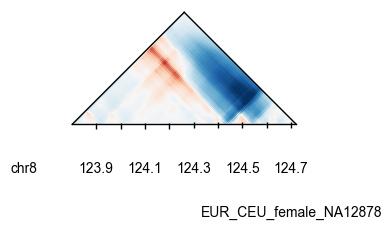

1/1 [==============================] - 1s 790ms/step


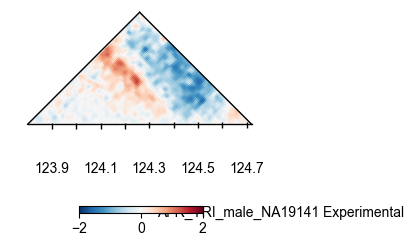

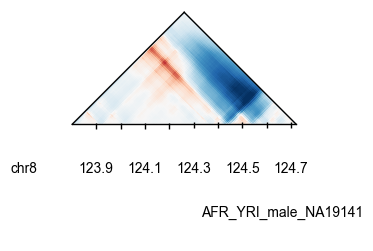

In [147]:
eur = 'EUR_CEU_female_NA12878'
afr = 'AFR_YRI_male_NA19141'
chrm = 'chr8'
wndw = 123740160

accession_eur = exp_indivs[exp_indivs.full_name==eur].accession.values[0]
genome_hic_cool_eur = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_eur, resolution))
exp_target_eur = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_eur, resolution)

ind_seq_eur = get_seq(chrm, wndw, eur)
ind_pred_eur = runAkitaPreds(ind_seq_eur)

_ = visualize_map_exp(exp_target_eur,eur, wndw, chrm, s=92, res=resolution, cbar=False, sat = 2)
_ = visualize_map_compressed(ind_pred_eur, wndw, eur, chrm, s=92, res=resolution, sat=2)

accession_afr = exp_indivs[exp_indivs.full_name==afr].accession.values[0]
genome_hic_cool_afr = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_afr, resolution))
exp_target_afr = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_afr, resolution)

ind_seq_afr = get_seq(chrm, wndw, afr)
ind_pred_afr = runAkitaPreds(ind_seq_afr)

_ = visualize_map_exp(exp_target_afr, afr, wndw, chrm, s=92, res=resolution, cbar=True, sat = 2)
_ = visualize_map_compressed(ind_pred_afr, wndw, afr, chrm, s=92, res=resolution, sat=2)


## Compare experimental to ancestral

In [42]:

def one_indiv_comps_anc(accession, resolution=10000, nbins=92):
    ind = exp_indivs[exp_indivs['accession']==accession]['full_name'].values[0]

    genome_hic_cool = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession, resolution))

    file_dict = {}
    with open('/wynton/group/capra/projects/modern_human_3Dgenome/data/akitaPreds/3dpreds/HFF_original/3dpreds_hsmrca_ancestral.txt') as file:
        lines1 = file.readlines()
        for i in range(len(lines1)):
            l1 = lines1[i]
            indiv1 = l1.strip().split("\t")
            indiv1_chr = indiv1[0]
            indiv1_pos = int(indiv1[1])
            indiv1 = list(map(float,indiv1[2:]))
            file_dict[(indiv1_chr, indiv1_pos)] = indiv1

    
    rhos = {}
    mses = {}
    counter = 0
    for chrm, wndw in list(zip(windows_to_keep.chr, windows_to_keep.windowStartPos)):
        keyi = (chrm, wndw)
        if counter % 1000 == 0:
            print("%s out of 4873" % counter)
        try:
            exp_target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool, resolution)
            #exp_mat = from_upper_triu(exp_target, nbins, 2)

            ind_pred = file_dict[keyi]
            ind_mat = from_upper_triu(ind_pred, 448, 2)
            ind_mat_compressed = ski.transform.resize(ind_mat, (nbins,nbins), anti_aliasing=False)
            
            rho, p = stats.spearmanr(exp_target, ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)])
            rhos[keyi] = rho

            mse = np.mean(np.square(exp_target - ind_mat_compressed[np.triu_indices(ind_mat_compressed.shape[0], k = 2)]))
            mses[keyi] = mse
        except:
            rhos[keyi] = np.NaN
            mses[keyi] = np.NaN

        counter += 1

    return mses, rhos

In [43]:
comp_data_anc = {}
for accession in accessions:
    ind = exp_indivs[exp_indivs['accession']==accession]['full_name'].values[0]
    print(ind)
    mses_anc, rhos_anc = one_indiv_comps_anc(accession)

    comp_data_anc[ind] = mses_anc, rhos_anc

comp_dfs = dict.fromkeys(comp_data_anc.keys())
for k in comp_data_anc.keys():
    a = pd.DataFrame.from_dict(comp_data_anc[k][0], orient='index')
    b = pd.DataFrame.from_dict(comp_data_anc[k][1], orient='index')
    c = pd.concat([a,b], axis=1)
    c.columns = ['mse','rho']
    comp_dfs_anc[k] = c

comps_df_anc = pd.concat(comp_dfs_anc, axis=1)
mse_anc = comps_df_anc.swaplevel(0,1, axis=1)['mse']
rho_anc = comps_df_anc.swaplevel(0,1, axis=1)['rho']
mse_anc.columns = mse_anc.columns.str.split('_', expand=True)
rho_anc.columns = rho_anc.columns.str.split('_', expand=True)

EUR_CEU_female_NA12878
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873
AFR_YRI_male_NA18486
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873
AFR_YRI_female_NA18505
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873
AFR_YRI_male_NA18507
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873
AFR_YRI_female_NA18508
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873
AFR_YRI_male_NA18516
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873
AFR_YRI_male_NA18522
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873
AFR_YRI_female_NA19099
0 out of 4873
1000 out of 4873
2000 out of 4873
3000 out of 4873
4000 out of 4873


# windows for Wanjun

In [13]:
exp_indivs

accession       id  filtered_reads          ancestor  genome_avg_mse  \
0   4DNFIL76YMY6  NA12878         3410.00  hsmrca_ancestral        0.000665   
1   4DNFI7N72M2A  NA18486          536.91  hsmrca_ancestral        0.000687   
2   4DNFIIDNWL5I  NA18505          356.06  hsmrca_ancestral        0.000684   
3   4DNFIEYSPGU1  NA18507          447.26  hsmrca_ancestral        0.000668   
4   4DNFI6SJZVXZ  NA18508          378.32  hsmrca_ancestral        0.000682   
5   4DNFIOF2U3HX  NA18516          358.07  hsmrca_ancestral        0.000717   
6   4DNFI2Y6GTWP  NA18522          292.44  hsmrca_ancestral        0.000646   
7   4DNFIKAC7MSF  NA19099          539.80  hsmrca_ancestral        0.000680   
8   4DNFIKMV9ZC7  NA19141          357.86  hsmrca_ancestral        0.000706   
9   4DNFI78T9N5Y  NA19204          535.11  hsmrca_ancestral        0.000663   
10  4DNFIIRNP38T  NA19238          464.03  hsmrca_ancestral        0.000662   
11  4DNFIO7M1D22  NA19239          468.57  hsmrca_ancestral        0.000685   
12  4DNFI66KARTU  HG00513          352.17  hsmrca_ancestral        0.000656   
13  4DNFIUZJP1ED  HG00731          319.74  hsmrca_ancestral        0.000659   
14  4DNFIFXDDDJ6  HG00732          381.71  hsmrca_ancestral        0.000658   

    genome_avg_spearman super_pop sub_pop     sex  divergence  \
0              0.995854       EUR     CEU  female    0.004146   
1              0.995574       AFR     YRI    male    0.004426   
2              0.995434       AFR     YRI  female    0.004566   
3              0.995687       AFR     YRI    male    0.004313   
4              0.995677       AFR     YRI  female    0.004323   
5              0.995268       AFR     YRI    male    0.004732   
6              0.995555       AFR     YRI    male    0.004445   
7              0.995421       AFR     YRI  female    0.004579   
8              0.995345       AFR     YRI    male    0.004655   
9              0.995752       AFR     YRI  female    0.004248   
10             0.995472       AFR     YRI  female    0.004528   
11             0.995384       AFR     YRI    male    0.004616   
12             0.995674       EAS     CHS  female    0.004326   
13             0.995709       AMR     PUR    male    0.004291   
14             0.995828       AMR     PUR  female    0.004172   

                 full_name  
0   EUR_CEU_female_NA12878  
1     AFR_YRI_male_NA18486  
2   AFR_YRI_female_NA18505  
3     AFR_YRI_male_NA18507  
4   AFR_YRI_female_NA18508  
5     AFR_YRI_male_NA18516  
6     AFR_YRI_male_NA18522  
7   AFR_YRI_female_NA19099  
8     AFR_YRI_male_NA19141  
9   AFR_YRI_female_NA19204  
10  AFR_YRI_female_NA19238  
11    AFR_YRI_male_NA19239  
12  EAS_CHS_female_HG00513  
13    AMR_PUR_male_HG00731  
14  AMR_PUR_female_HG00732

In [16]:
positive = ['EAS_CHS_female_HG00513',
       'AFR_YRI_male_NA18507',
       'AFR_YRI_male_NA18516',
       'AFR_YRI_male_NA18522',
       'AFR_YRI_female_NA19099',
       'AFR_YRI_male_NA19141',
       'AFR_YRI_male_NA19239']
negative = ['EUR_CEU_female_NA12878',
       'AFR_YRI_male_NA18486',
       'AFR_YRI_female_NA18505',
       'AFR_YRI_female_NA18508',
       'AFR_YRI_female_NA19204',
       'AFR_YRI_female_NA19238',
       'AMR_PUR_male_HG00731',
       'AMR_PUR_female_HG00732'
       ]

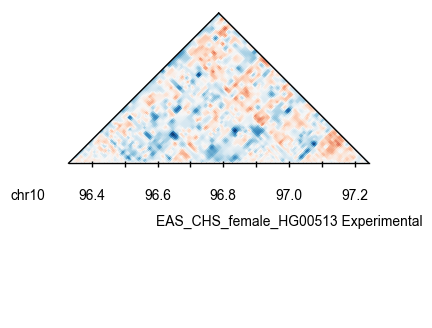

In [50]:
pos_ind = positive[0]
chrm = 'chr10'
wndw = 96265532
resolution = 5000
accession_positive = exp_indivs[exp_indivs.full_name==pos_ind].accession.values[0]
genome_hic_cool_positive = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_positive, resolution))
exp_target_positive = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_positive, resolution)

ind_seq_positive = get_seq(chrm, wndw, pos_ind)
#ind_pred_positive = runAkitaPreds(ind_seq_positive)

_ = visualize_map_exp(exp_target_positive,pos_ind, wndw, chrm, s=183, res=resolution, cbar=False, sat = 2)
#_ = visualize_map_compressed(ind_pred_positive, wndw, pos_ind, chrm, s=92, res=resolution, sat=2)


1/1 [==============================] - 3s 3s/step


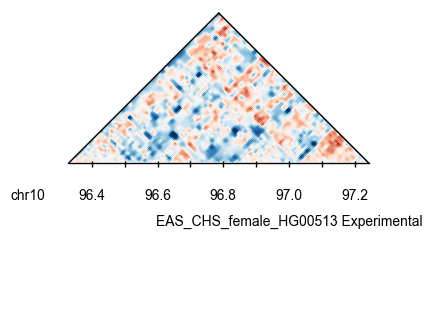

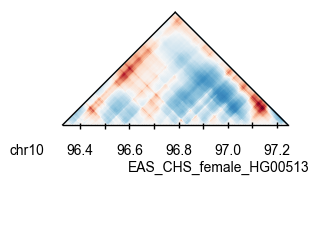

1/1 [==============================] - 2s 2s/step


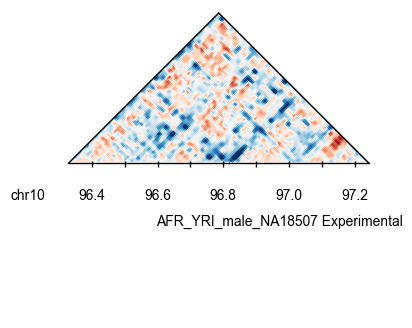

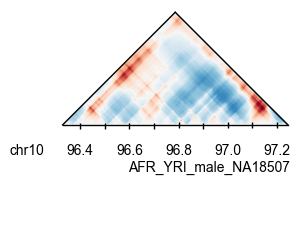

1/1 [==============================] - 2s 2s/step


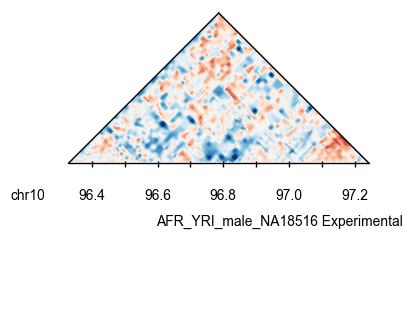

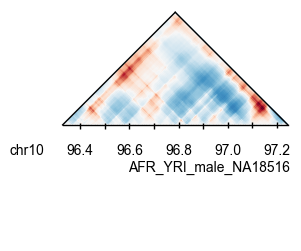

1/1 [==============================] - 2s 2s/step


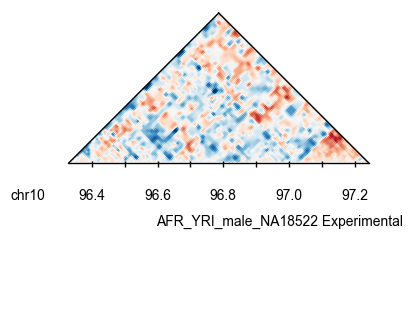

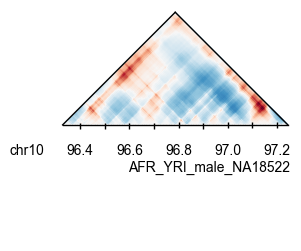

1/1 [==============================] - 2s 2s/step


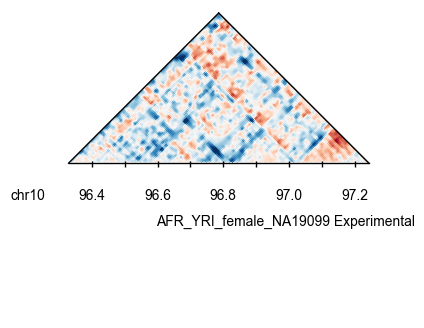

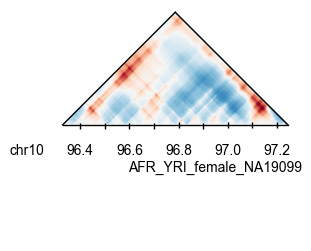

1/1 [==============================] - 2s 2s/step


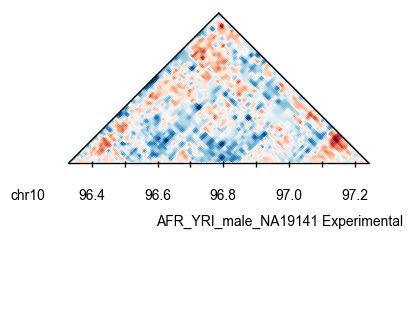

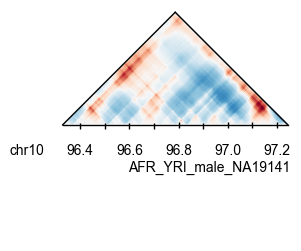

1/1 [==============================] - 2s 2s/step


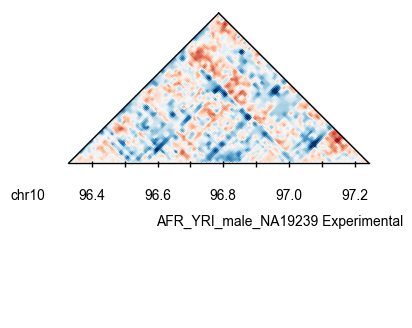

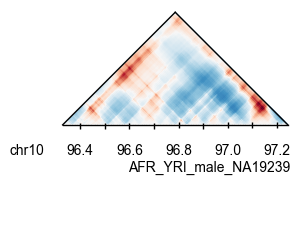

In [51]:
for i in positive:
    pos_ind = i
    chrm = 'chr10'
    wndw = 96265532
    resolution = 5000
    accession_positive = exp_indivs[exp_indivs.full_name==pos_ind].accession.values[0]
    genome_hic_cool_positive = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_positive, resolution))
    exp_target_positive = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_positive, resolution)

    ind_seq_positive = get_seq(chrm, wndw, pos_ind)
    ind_pred_positive = runAkitaPreds(ind_seq_positive)

    _ = visualize_map_exp(exp_target_positive,pos_ind, wndw, chrm, s=183, res=resolution, cbar=False, sat = 1.5)
    _ = visualize_map_compressed(ind_pred_positive, wndw, pos_ind, chrm, s=183, res=resolution, sat=1.5)


1/1 [==============================] - 2s 2s/step


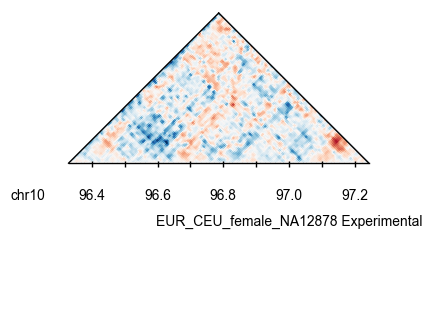

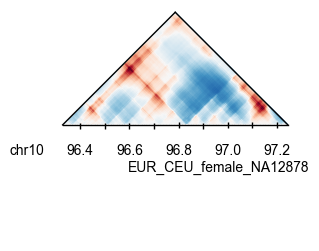

1/1 [==============================] - 2s 2s/step


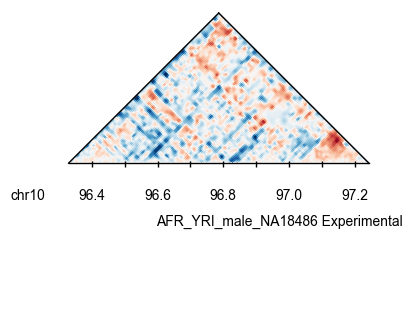

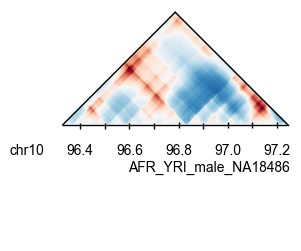

1/1 [==============================] - 2s 2s/step


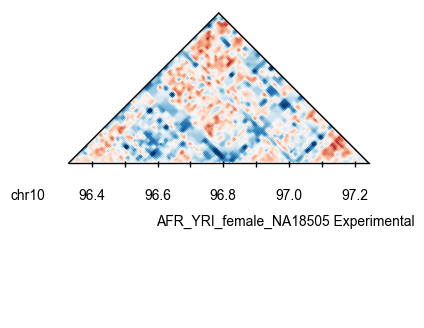

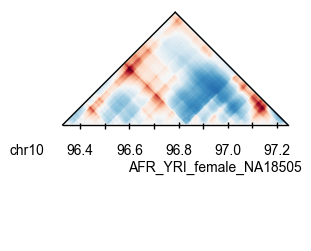

1/1 [==============================] - 2s 2s/step


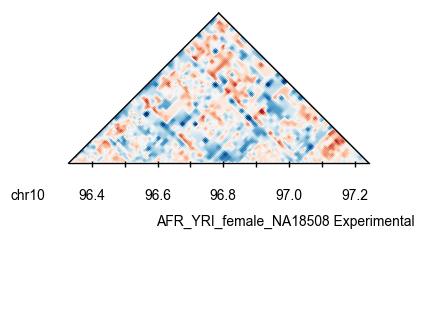

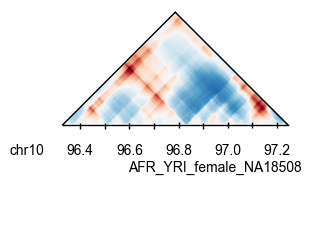

1/1 [==============================] - 2s 2s/step


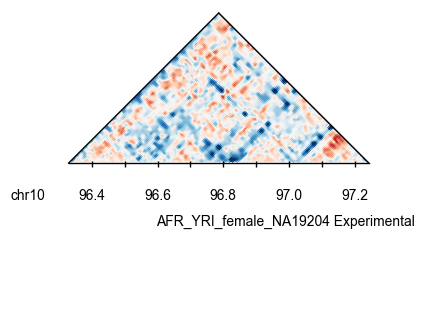

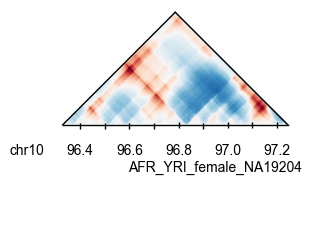

1/1 [==============================] - 2s 2s/step


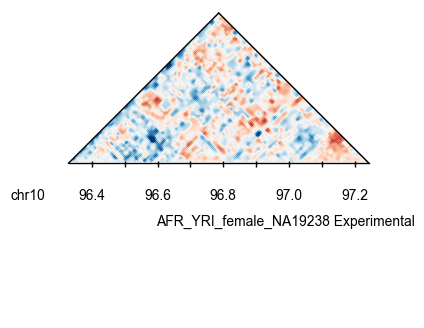

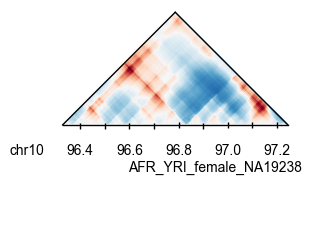

1/1 [==============================] - 2s 2s/step


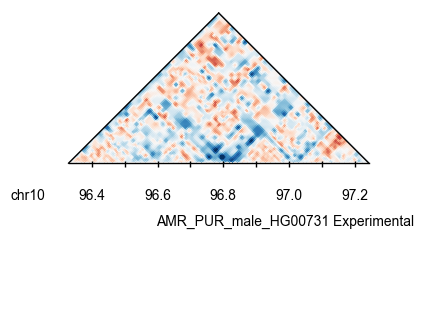

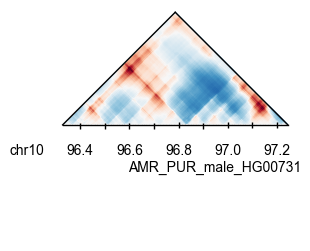

1/1 [==============================] - 2s 2s/step


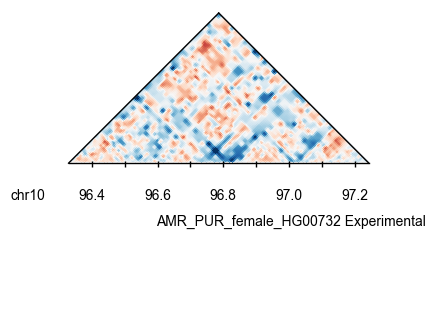

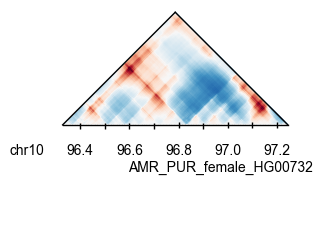

In [54]:
for i in negative:
    neg_ind = i
    chrm = 'chr10'
    wndw = 96265532
    resolution = 5000
    accession_negative = exp_indivs[exp_indivs.full_name==neg_ind].accession.values[0]
    genome_hic_cool_positive = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_negative, resolution))
    exp_target_negative = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_positive, resolution)

    ind_seq_negative = get_seq(chrm, wndw, neg_ind)
    ind_pred_negative = runAkitaPreds(ind_seq_negative)

    _ = visualize_map_exp(exp_target_negative,neg_ind, wndw, chrm, s=183, res=resolution, cbar=False, sat = 1.5)
    _ = visualize_map_compressed(ind_pred_negative, wndw, neg_ind, chrm, s=183, res=resolution, sat=1.5)


In [31]:
def comparePreds(ref, alt):
    mse = np.mean(np.square(ref - alt))
    spearman = stats.spearmanr(ref, alt)[0]
    divergence = 1 - spearman
    return (mse, divergence)

In [33]:
comparePreds(exp_target_positive, exp_target_negative)

(0.07623, 0.3941057602791883)

In [34]:
comparePreds(ind_pred_positive, ind_pred_negative)

(0.031812582, 0.07032997766701943)

In [43]:
pred_divergence_df = pd.DataFrame(index = positive, columns = negative)
exp_divergence_df = pd.DataFrame(index = positive, columns = negative)

In [55]:
chrm = 'chr10'
wndw = 96265532
resolution = 5000
for p in positive:
    pos_ind = p
    accession_positive = exp_indivs[exp_indivs.full_name==pos_ind].accession.values[0]
    genome_hic_cool_positive = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_positive, resolution))
    exp_target_positive = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_positive, resolution)
    ind_seq_positive = get_seq(chrm, wndw, pos_ind)
    ind_pred_positive = runAkitaPreds(ind_seq_positive)

    for n in negative:
        neg_ind = n
        accession_negative = exp_indivs[exp_indivs.full_name==neg_ind].accession.values[0]
        genome_hic_cool_positive = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/%s.mcool::resolutions/%s' % (accession_negative, resolution))
        exp_target_negative = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool_positive, resolution)
        ind_seq_negative = get_seq(chrm, wndw, neg_ind)
        ind_pred_negative = runAkitaPreds(ind_seq_negative)
        
        pred_mse, pred_div = comparePreds(ind_pred_positive, ind_pred_negative)
        pred_divergence_df.loc[p][n] = pred_div

        exp_mse, exp_div = comparePreds(exp_target_positive, exp_target_negative)
        exp_divergence_df.loc[p][n] = exp_div

1/1 [==============================] - 2s 2s/step


In [45]:
pred_divergence_df

EUR_CEU_female_NA12878 AFR_YRI_male_NA18486  \
EAS_CHS_female_HG00513               0.062363              0.06636   
AFR_YRI_male_NA18507                 0.067301             0.071509   
AFR_YRI_male_NA18516                 0.071979             0.075413   
AFR_YRI_male_NA18522                 0.066295             0.069683   
AFR_YRI_female_NA19099                0.06824             0.072106   
AFR_YRI_male_NA19141                 0.066593             0.069507   
AFR_YRI_male_NA19239                 0.066202             0.070058   

                       AFR_YRI_female_NA18505 AFR_YRI_female_NA18508  \
EAS_CHS_female_HG00513               0.067176               0.066904   
AFR_YRI_male_NA18507                 0.070362                0.07044   
AFR_YRI_male_NA18516                 0.074068               0.076067   
AFR_YRI_male_NA18522                 0.069027               0.069637   
AFR_YRI_female_NA19099               0.070549               0.071546   
AFR_YRI_male_NA19141                 0.068075               0.068354   
AFR_YRI_male_NA19239                 0.070525               0.070905   

                       AFR_YRI_female_NA19204 AFR_YRI_female_NA19238  \
EAS_CHS_female_HG00513               0.070322               0.060976   
AFR_YRI_male_NA18507                 0.075003               0.066426   
AFR_YRI_male_NA18516                 0.079641               0.069503   
AFR_YRI_male_NA18522                 0.073323               0.064475   
AFR_YRI_female_NA19099               0.076149               0.067099   
AFR_YRI_male_NA19141                 0.072212               0.065909   
AFR_YRI_male_NA19239                  0.07432               0.064201   

                       AMR_PUR_male_HG00731 AMR_PUR_female_HG00732  
EAS_CHS_female_HG00513              0.06203               0.066613  
AFR_YRI_male_NA18507               0.068069                0.07178  
AFR_YRI_male_NA18516               0.070785               0.075647  
AFR_YRI_male_NA18522               0.066061               0.069874  
AFR_YRI_female_NA19099             0.068182               0.072288  
AFR_YRI_male_NA19141               0.067763                0.06959  
AFR_YRI_male_NA19239               0.065247                0.07033

In [46]:
exp_divergence_df

EUR_CEU_female_NA12878 AFR_YRI_male_NA18486  \
EAS_CHS_female_HG00513                0.27342             0.330353   
AFR_YRI_male_NA18507                  0.28016             0.333381   
AFR_YRI_male_NA18516                 0.262149             0.321536   
AFR_YRI_male_NA18522                 0.360214             0.387383   
AFR_YRI_female_NA19099               0.220057             0.279535   
AFR_YRI_male_NA19141                 0.305465             0.332422   
AFR_YRI_male_NA19239                 0.285578             0.320383   

                       AFR_YRI_female_NA18505 AFR_YRI_female_NA18508  \
EAS_CHS_female_HG00513               0.441259               0.383357   
AFR_YRI_male_NA18507                 0.372142                0.32469   
AFR_YRI_male_NA18516                 0.417891               0.360408   
AFR_YRI_male_NA18522                   0.4358               0.445813   
AFR_YRI_female_NA19099               0.365945               0.296595   
AFR_YRI_male_NA19141                 0.384977               0.368718   
AFR_YRI_male_NA19239                 0.404271               0.343326   

                       AFR_YRI_female_NA19204 AFR_YRI_female_NA19238  \
EAS_CHS_female_HG00513               0.376263               0.362887   
AFR_YRI_male_NA18507                  0.31824               0.319818   
AFR_YRI_male_NA18516                 0.334794                0.37688   
AFR_YRI_male_NA18522                 0.393737               0.440508   
AFR_YRI_female_NA19099               0.275377                0.27038   
AFR_YRI_male_NA19141                 0.312399               0.354814   
AFR_YRI_male_NA19239                 0.323009               0.353482   

                       AMR_PUR_male_HG00731 AMR_PUR_female_HG00732  
EAS_CHS_female_HG00513             0.489194               0.440581  
AFR_YRI_male_NA18507               0.451061               0.373956  
AFR_YRI_male_NA18516               0.506803               0.371702  
AFR_YRI_male_NA18522                 0.5381               0.475651  
AFR_YRI_female_NA19099             0.460046               0.317908  
AFR_YRI_male_NA19141               0.475708               0.417312  
AFR_YRI_male_NA19239               0.483774               0.394106